In [1]:
# Cella 1: Installazione pacchetti base
!pip install numpy pandas matplotlib seaborn pillow opencv-python

# Cella 2: Installazione TensorFlow (versione CPU)
!pip install tensorflow

# Cella 3: Installazione OpenCV
!pip install opencv-python

# Cella 4: (Opzionale) Per accelerare operazioni su CPU
!pip install tensorflow-addons

# Cella 5: (Opzionale) Per visualizzazioni avanzate
!pip install plotly

# Cella 1: Installazione Ultralytics YOLO11
!pip install ultralytics

!pip install albumentations

!pip install tensorboard

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [1]:
import sys
print(f"Python version: {sys.version}")
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
import cv2
print(f"OpenCV version: {cv2.__version__}")

Python version: 3.11.13 (main, Jun  3 2025, 18:38:25) [Clang 17.0.0 (clang-1700.0.13.3)]
The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
TensorFlow version: 2.19.0
OpenCV version: 4.11.0


In [2]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.148 🚀 Python-3.11.13 torch-2.7.0 CPU (Apple M1 Pro)
Setup complete ✅ (10 CPUs, 16.0 GB RAM, 759.1/926.4 GB disk)


In [7]:
# ====================================
# IMPORT LIBRERIE
# ====================================
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from PIL import Image
import shutil
from collections import Counter
import random
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

class YOLOFallDetectionTrainer:
    def __init__(self, dataset_path, model_name='yolo11n.pt', img_size=640):
        """
        Inizializza il trainer per YOLO11 Fall Detection
        
        Args:
            dataset_path: Path alla directory del dataset in formato YOLO
            model_name: Modello YOLO11 da usare (yolo11n.pt per CPU)
            img_size: Dimensione immagini per training
        """
        self.dataset_path = Path(dataset_path)
        self.model_name = model_name
        self.img_size = img_size
        self.data_yaml_path = self.dataset_path / 'data.yaml'
        
        # Mapping delle classi
        self.class_names = {0: 'not_fallen', 1: 'fallen'}
        
    def analyze_dataset(self):
        """Analisi completa del dataset YOLO"""
        print("=" * 60)
        print("ANALISI DATASET YOLO - FALL DETECTION")
        print("=" * 60)
        
        # Verifica struttura dataset (adattata alla tua struttura)
        images_train_path = self.dataset_path / 'images' / 'train'
        images_val_path = self.dataset_path / 'images' / 'val'
        images_test_path = self.dataset_path / 'images' / 'test'
        
        labels_train_path = self.dataset_path / 'labels' / 'train'
        labels_val_path = self.dataset_path / 'labels' / 'val'
        labels_test_path = self.dataset_path / 'labels' / 'test'
        
        print(f"\n📁 Struttura Dataset:")
        print(f"  • Images:")
        print(f"    - Train: {'✅' if images_train_path.exists() else '❌'} {images_train_path}")
        print(f"    - Val: {'✅' if images_val_path.exists() else '❌'} {images_val_path}")
        print(f"    - Test: {'✅' if images_test_path.exists() else '❌'} {images_test_path}")
        print(f"  • Labels:")
        print(f"    - Train: {'✅' if labels_train_path.exists() else '❌'} {labels_train_path}")
        print(f"    - Val: {'✅' if labels_val_path.exists() else '❌'} {labels_val_path}")
        print(f"    - Test: {'✅' if labels_test_path.exists() else '❌'} {labels_test_path}")
        
        # Analisi delle classi
        class_distribution = self._analyze_class_distribution()
        
        # Analisi delle bounding box
        bbox_stats = self._analyze_bounding_boxes()
        
        # Analisi qualità immagini
        image_quality = self._analyze_image_quality()
        
        # Visualizzazioni
        self._plot_dataset_analysis(class_distribution, bbox_stats, image_quality)
        
        return class_distribution, bbox_stats
    
    def _analyze_class_distribution(self):
        """Analizza la distribuzione delle classi nel dataset"""
        distribution = {'train': {0: 0, 1: 0}, 'val': {0: 0, 1: 0}, 'test': {0: 0, 1: 0}}
        
        for split in ['train', 'val', 'test']:
            labels_path = self.dataset_path / 'labels' / split
            if labels_path.exists():
                for label_file in labels_path.glob('*.txt'):
                    with open(label_file, 'r') as f:
                        lines = f.readlines()
                        for line in lines:
                            if line.strip():
                                class_id = int(line.split()[0])
                                distribution[split][class_id] += 1
        
        print(f"\n📊 Distribuzione Classi:")
        for split, counts in distribution.items():
            if sum(counts.values()) > 0:
                print(f"\n  {split.upper()}:")
                total = sum(counts.values())
                for class_id, count in counts.items():
                    percentage = (count / total * 100) if total > 0 else 0
                    print(f"    • {self.class_names[class_id]}: {count} ({percentage:.1f}%)")
                
                # Calcola imbalance ratio
                if counts[0] > 0 and counts[1] > 0:
                    imbalance = max(counts.values()) / min(counts.values())
                    print(f"    • Imbalance ratio: {imbalance:.2f}")
                    if imbalance > 2:
                        print(f"    ⚠️  Dataset sbilanciato! Considera data augmentation mirata")
        
        return distribution
    
    def _analyze_bounding_boxes(self):
        """Analizza le dimensioni delle bounding box"""
        bbox_stats = {'widths': [], 'heights': [], 'areas': [], 'aspects': []}
        
        labels_path = self.dataset_path / 'labels' / 'train'
        images_path = self.dataset_path / 'images' / 'train'
        
        if labels_path.exists() and images_path.exists():
            for label_file in list(labels_path.glob('*.txt'))[:100]:  # Sample 100 files
                img_name = label_file.stem + '.jpg'
                img_path = images_path / img_name
                
                if img_path.exists():
                    # Leggi dimensioni immagine
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        h, w = img.shape[:2]
                        
                        # Leggi bounding box
                        with open(label_file, 'r') as f:
                            for line in f.readlines():
                                if line.strip():
                                    parts = line.strip().split()
                                    if len(parts) >= 5:
                                        _, x_center, y_center, width, height = map(float, parts[:5])
                                        
                                        # Converti da normalizzate a pixel
                                        bbox_w = width * w
                                        bbox_h = height * h
                                        
                                        bbox_stats['widths'].append(bbox_w)
                                        bbox_stats['heights'].append(bbox_h)
                                        bbox_stats['areas'].append(bbox_w * bbox_h)
                                        bbox_stats['aspects'].append(bbox_w / bbox_h if bbox_h > 0 else 0)
        
        if bbox_stats['widths']:
            print(f"\n📏 Statistiche Bounding Box:")
            print(f"  • Larghezza media: {np.mean(bbox_stats['widths']):.1f}px")
            print(f"  • Altezza media: {np.mean(bbox_stats['heights']):.1f}px")
            print(f"  • Area media: {np.mean(bbox_stats['areas']):.1f}px²")
            print(f"  • Aspect ratio medio: {np.mean(bbox_stats['aspects']):.2f}")
        
        return bbox_stats
    
    def _analyze_image_quality(self):
        """Analizza la qualità delle immagini (luminosità, contrasto)"""
        quality_stats = {'brightness': [], 'contrast': [], 'sharpness': []}
        
        images_path = self.dataset_path / 'images' / 'train'
        if images_path.exists():
            sample_images = list(images_path.glob('*.jpg'))[:50]  # Sample 50 images
            
            for img_path in sample_images:
                img = cv2.imread(str(img_path))
                if img is not None:
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    
                    # Brightness
                    quality_stats['brightness'].append(np.mean(gray))
                    
                    # Contrast
                    quality_stats['contrast'].append(np.std(gray))
                    
                    # Sharpness (usando Laplacian)
                    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
                    quality_stats['sharpness'].append(laplacian.var())
        
        if quality_stats['brightness']:
            print(f"\n🖼️ Qualità Immagini:")
            print(f"  • Luminosità media: {np.mean(quality_stats['brightness']):.1f}")
            print(f"  • Contrasto medio: {np.mean(quality_stats['contrast']):.1f}")
            print(f"  • Nitidezza media: {np.mean(quality_stats['sharpness']):.1f}")
            
            if np.mean(quality_stats['brightness']) < 50:
                print(f"  ⚠️  Immagini molto scure - applicherò augmentation luminosità")
            elif np.mean(quality_stats['brightness']) > 200:
                print(f"  ⚠️  Immagini molto chiare - attenzione a sovraesposizione")
        
        return quality_stats
    
    def _plot_dataset_analysis(self, class_distribution, bbox_stats, image_quality):
        """Visualizza i risultati dell'analisi"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Analisi Dataset YOLO - Fall Detection', fontsize=16, fontweight='bold')
        
        # 1. Distribuzione classi per split
        ax = axes[0, 0]
        splits = ['train', 'val', 'test']
        not_fallen_counts = [class_distribution[split][0] for split in splits]
        fallen_counts = [class_distribution[split][1] for split in splits]
        
        x = np.arange(len(splits))
        width = 0.35
        
        ax.bar(x - width/2, not_fallen_counts, width, label='not_fallen', color='#2ecc71')
        ax.bar(x + width/2, fallen_counts, width, label='fallen', color='#e74c3c')
        
        ax.set_xlabel('Dataset Split')
        ax.set_ylabel('Numero di Annotazioni')
        ax.set_title('Distribuzione Classi per Split')
        ax.set_xticks(x)
        ax.set_xticklabels(splits)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Distribuzione dimensioni bbox
        ax = axes[0, 1]
        if bbox_stats['areas']:
            ax.hist(bbox_stats['areas'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
            ax.set_xlabel('Area Bounding Box (px²)')
            ax.set_ylabel('Frequenza')
            ax.set_title('Distribuzione Dimensioni Bounding Box')
            ax.grid(True, alpha=0.3)
        
        # 3. Aspect ratio bbox
        ax = axes[0, 2]
        if bbox_stats['aspects']:
            ax.hist(bbox_stats['aspects'], bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
            ax.set_xlabel('Aspect Ratio (W/H)')
            ax.set_ylabel('Frequenza')
            ax.set_title('Distribuzione Aspect Ratio')
            ax.grid(True, alpha=0.3)
        
        # 4. Luminosità immagini
        ax = axes[1, 0]
        if image_quality['brightness']:
            ax.boxplot([image_quality['brightness']], labels=['Brightness'])
            ax.set_ylabel('Valore (0-255)')
            ax.set_title('Distribuzione Luminosità')
            ax.grid(True, alpha=0.3)
        
        # 5. Contrasto immagini
        ax = axes[1, 1]
        if image_quality['contrast']:
            ax.boxplot([image_quality['contrast']], labels=['Contrast'])
            ax.set_ylabel('Deviazione Standard')
            ax.set_title('Distribuzione Contrasto')
            ax.grid(True, alpha=0.3)
        
        # 6. Sample di immagini con annotazioni
        ax = axes[1, 2]
        self._plot_sample_annotations(ax)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_sample_annotations(self, ax):
        """Mostra un esempio di immagine con annotazioni"""
        images_path = self.dataset_path / 'images' / 'train'
        labels_path = self.dataset_path / 'labels' / 'train'
        
        if images_path.exists() and labels_path.exists():
            # Trova un'immagine con annotazioni
            for img_file in images_path.glob('*.jpg'):
                label_file = labels_path / (img_file.stem + '.txt')
                if label_file.exists():
                    img = cv2.imread(str(img_file))
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        h, w = img.shape[:2]
                        
                        # Leggi e disegna bbox
                        with open(label_file, 'r') as f:
                            for line in f.readlines():
                                if line.strip():
                                    parts = line.strip().split()
                                    if len(parts) >= 5:
                                        class_id, x_c, y_c, width, height = map(float, parts[:5])
                                        
                                        # Converti a coordinate pixel
                                        x1 = int((x_c - width/2) * w)
                                        y1 = int((y_c - height/2) * h)
                                        x2 = int((x_c + width/2) * w)
                                        y2 = int((y_c + height/2) * h)
                                        
                                        # Disegna bbox
                                        color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
                                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                                        
                                        # Aggiungi label
                                        label = self.class_names[int(class_id)]
                                        cv2.putText(img, label, (x1, y1-10), 
                                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                        
                        ax.imshow(img)
                        ax.set_title('Esempio Annotazioni')
                        ax.axis('off')
                        break
    
    def create_augmented_dataset(self, augmentation_factor=3, show_examples=True):
        """Crea un dataset augmentato con focus su occlusioni e variazioni luminosità"""
        print("\n" + "="*60)
        print("CREAZIONE DATASET AUGMENTATO")
        print("="*60)
        
        # Definisci pipeline di augmentation
        transform = A.Compose([
            # Variazioni di luminosità estreme
            A.RandomBrightnessContrast(
                brightness_limit=0.4,
                contrast_limit=0.4,
                p=0.8
            ),
            
            # Simulazione diverse condizioni di luce
            A.OneOf([
                A.RandomGamma(gamma_limit=(60, 140), p=1),
                A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=30, p=1),
                A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1),
            ], p=0.7),
            
            # Occlusioni
            A.OneOf([
                A.CoarseDropout(
                    max_holes=3,
                    max_height=0.2,
                    max_width=0.2,
                    min_holes=1,
                    fill_value=0,
                    p=1
                ),
                A.GridDropout(
                    ratio=0.3,
                    unit_size_range=(10, 20),
                    p=1
                ),
            ], p=0.6),
            
            # Blur e rumore
            A.OneOf([
                A.MotionBlur(blur_limit=5, p=1),
                A.GaussianBlur(blur_limit=5, p=1),
                A.MedianBlur(blur_limit=5, p=1),
            ], p=0.3),
            
            A.OneOf([
                A.GaussNoise(var_limit=(10, 50), p=1),
                A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1),
            ], p=0.3),
            
            # Trasformazioni geometriche
            A.ShiftScaleRotate(
                shift_limit=0.1,
                scale_limit=0.2,
                rotate_limit=15,
                border_mode=cv2.BORDER_CONSTANT,
                p=0.5
            ),
            
            A.HorizontalFlip(p=0.5),
            A.Perspective(scale=(0.05, 0.1), p=0.3),
            
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
        
        # Statistiche per analisi
        stats = {
            'original': {'images': 0, 'not_fallen': 0, 'fallen': 0},
            'augmented': {'images': 0, 'not_fallen': 0, 'fallen': 0},
            'failed': {'images': [], 'reasons': {}},
            'problematic_bbox': []
        }
        
        # Crea nuovo dataset path
        parent_dir = self.dataset_path.parent
        aug_dataset_path = parent_dir / 'augmented_yolo_dataset'
        
        # Crea struttura directory
        for split in ['train', 'val', 'test']:
            (aug_dataset_path / 'images' / split).mkdir(parents=True, exist_ok=True)
            (aug_dataset_path / 'labels' / split).mkdir(parents=True, exist_ok=True)
        
        # Directory per esempi di augmentation
        examples_dir = aug_dataset_path / 'augmentation_examples'
        examples_dir.mkdir(exist_ok=True)
        
        print(f"\n📁 Creando nuovo dataset in: {aug_dataset_path}")
        
        # Mostra esempi di augmentation prima di processare tutto
        if show_examples:
            self._show_augmentation_examples(transform, examples_dir)
        
        # Processa ogni split
        for split in ['train', 'val', 'test']:
            orig_images = self.dataset_path / 'images' / split
            orig_labels = self.dataset_path / 'labels' / split
            
            aug_images = aug_dataset_path / 'images' / split
            aug_labels = aug_dataset_path / 'labels' / split
            
            if not orig_images.exists():
                print(f"⚠️  Skip {split}: directory non trovata")
                continue
            
            print(f"\n📁 Processando {split}...")
            
            # Analizza e copia originali
            for img_file in orig_images.glob('*.jpg'):
                shutil.copy2(img_file, aug_images / img_file.name)
                label_file = orig_labels / (img_file.stem + '.txt')
                
                if label_file.exists():
                    shutil.copy2(label_file, aug_labels / label_file.name)
                    
                    # Conta classi originali
                    with open(label_file, 'r') as f:
                        for line in f:
                            if line.strip():
                                class_id = int(line.split()[0])
                                if class_id == 0:
                                    stats['original']['not_fallen'] += 1
                                else:
                                    stats['original']['fallen'] += 1
                    
                    stats['original']['images'] += 1
            
            # Applica augmentation solo al training set
            if split == 'train':
                print(f"  • Applicando augmentation (fattore: {augmentation_factor}x)...")
                
                successful_aug = 0
                failed_aug = 0
                
                # Progress tracking
                total_images = len(list(orig_images.glob('*.jpg')))
                processed = 0
                
                for img_file in orig_images.glob('*.jpg'):
                    processed += 1
                    if processed % 100 == 0:
                        print(f"    Processate {processed}/{total_images} immagini...")
                    
                    label_file = orig_labels / (img_file.stem + '.txt')
                    
                    if label_file.exists():
                        # Leggi immagine e annotazioni
                        image = cv2.imread(str(img_file))
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        
                        # Analizza bbox originali
                        bboxes = []
                        class_labels = []
                        
                        with open(label_file, 'r') as f:
                            for line in f.readlines():
                                if line.strip():
                                    parts = line.strip().split()
                                    if len(parts) >= 5:
                                        class_id = int(parts[0])
                                        bbox = list(map(float, parts[1:5]))
                                        
                                        # Check bbox problematiche
                                        x, y, w, h = bbox
                                        if (x - w/2 < 0.001 or x + w/2 > 0.999 or 
                                            y - h/2 < 0.001 or y + h/2 > 0.999):
                                            stats['problematic_bbox'].append({
                                                'file': img_file.name,
                                                'bbox': bbox,
                                                'issue': 'near_border'
                                            })
                                        
                                        bboxes.append(bbox)
                                        class_labels.append(class_id)
                        
                        # Applica augmentation multiple volte
                        aug_success_count = 0
                        for i in range(augmentation_factor):
                            try:
                                # Pre-processa bbox vicine ai bordi
                                safe_bboxes = []
                                for bbox in bboxes:
                                    x, y, w, h = bbox
                                    # Porta le bbox leggermente all'interno
                                    x = np.clip(x, w/2 + 0.001, 1 - w/2 - 0.001)
                                    y = np.clip(y, h/2 + 0.001, 1 - h/2 - 0.001)
                                    safe_bboxes.append([x, y, w, h])
                                
                                # Applica trasformazioni
                                transformed = transform(image=image, bboxes=safe_bboxes, class_labels=class_labels)
                                
                                # Valida e salva solo se ci sono bbox valide
                                if transformed['bboxes']:
                                    # Salva immagine
                                    aug_img_name = f"{img_file.stem}_aug_{i}.jpg"
                                    aug_img_path = aug_images / aug_img_name
                                    aug_image = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
                                    cv2.imwrite(str(aug_img_path), aug_image)
                                    
                                    # Salva annotazioni
                                    aug_label_path = aug_labels / f"{img_file.stem}_aug_{i}.txt"
                                    with open(aug_label_path, 'w') as f:
                                        for bbox, class_id in zip(transformed['bboxes'], transformed['class_labels']):
                                            # Validazione finale
                                            x, y, w, h = bbox
                                            if 0 < x < 1 and 0 < y < 1 and 0 < w < 1 and 0 < h < 1:
                                                f.write(f"{class_id} {x} {y} {w} {h}\n")
                                                
                                                # Conta classi augmentate
                                                if class_id == 0:
                                                    stats['augmented']['not_fallen'] += 1
                                                else:
                                                    stats['augmented']['fallen'] += 1
                                    
                                    aug_success_count += 1
                                    stats['augmented']['images'] += 1
                                    
                            except Exception as e:
                                error_type = type(e).__name__
                                if error_type not in stats['failed']['reasons']:
                                    stats['failed']['reasons'][error_type] = 0
                                stats['failed']['reasons'][error_type] += 1
                                
                                if len(stats['failed']['images']) < 10:  # Salva solo primi 10
                                    stats['failed']['images'].append({
                                        'file': img_file.name,
                                        'error': str(e)
                                    })
                        
                        if aug_success_count == augmentation_factor:
                            successful_aug += 1
                        else:
                            failed_aug += 1
                
                print(f"\n  ✅ Augmentation completata:")
                print(f"    • Immagini processate con successo: {successful_aug}")
                print(f"    • Immagini con errori parziali: {failed_aug}")
        
        # Analisi finale e report
        self._generate_augmentation_report(stats, aug_dataset_path)
        
        # Crea data.yaml
        data_config = {
            'path': str(aug_dataset_path.absolute()),
            'train': 'images/train',
            'val': 'images/val',
            'test': 'images/test',
            'names': {
                0: 'not_fallen',
                1: 'fallen'
            },
            'nc': 2
        }
        
        with open(aug_dataset_path / 'data.yaml', 'w') as f:
            yaml.dump(data_config, f, default_flow_style=False)
        
        # Aggiorna path
        self.dataset_path = aug_dataset_path
        self.data_yaml_path = aug_dataset_path / 'data.yaml'
        
        return aug_dataset_path

    def _show_augmentation_examples(self, transform, examples_dir):
        """Mostra esempi di augmentation applicata"""
        print("\n🎨 ESEMPI DI AUGMENTATION")
        print("="*40)
        
        # Seleziona immagini campione
        train_images = self.dataset_path / 'images' / 'train'
        sample_images = list(train_images.glob('*.jpg'))[:3]  # 3 esempi
        
        fig, axes = plt.subplots(len(sample_images), 5, figsize=(20, 4*len(sample_images)))
        if len(sample_images) == 1:
            axes = axes.reshape(1, -1)
        
        augmentation_types = [
            "Originale",
            "Brightness/Contrast", 
            "Occlusioni",
            "Blur/Noise",
            "Geometrica"
        ]
        
        for idx, img_path in enumerate(sample_images):
            # Carica immagine e label
            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w = image.shape[:2]
            
            label_path = self.dataset_path / 'labels' / 'train' / (img_path.stem + '.txt')
            bboxes = []
            class_labels = []
            
            if label_path.exists():
                with open(label_path, 'r') as f:
                    for line in f:
                        if line.strip():
                            parts = line.strip().split()
                            class_id = int(parts[0])
                            bbox = list(map(float, parts[1:5]))
                            bboxes.append(bbox)
                            class_labels.append(class_id)
            
            # Mostra originale
            ax = axes[idx, 0]
            img_show = image.copy()
            
            # Disegna bbox
            for bbox, class_id in zip(bboxes, class_labels):
                x_c, y_c, width, height = bbox
                x1 = int((x_c - width/2) * w)
                y1 = int((y_c - height/2) * h)
                x2 = int((x_c + width/2) * w)
                y2 = int((y_c + height/2) * h)
                
                color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
                cv2.rectangle(img_show, (x1, y1), (x2, y2), color, 2)
                label = 'not_fallen' if class_id == 0 else 'fallen'
                cv2.putText(img_show, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            ax.imshow(img_show)
            ax.set_title(f"{augmentation_types[0]}\n{img_path.name}", fontsize=10)
            ax.axis('off')
            
            # Applica e mostra diverse augmentation
            for aug_idx in range(1, 5):
                try:
                    # Applica transform
                    safe_bboxes = [[np.clip(x, w/2+0.01, 1-w/2-0.01), 
                                np.clip(y, h/2+0.01, 1-h/2-0.01), w, h] 
                                for x, y, w, h in bboxes]
                    
                    transformed = transform(image=image, bboxes=safe_bboxes, class_labels=class_labels)
                    
                    # Visualizza
                    ax = axes[idx, aug_idx]
                    aug_img = transformed['image'].copy()
                    
                    # Disegna bbox trasformate
                    for bbox, class_id in zip(transformed['bboxes'], transformed['class_labels']):
                        x_c, y_c, width, height = bbox
                        x1 = int((x_c - width/2) * w)
                        y1 = int((y_c - height/2) * h)
                        x2 = int((x_c + width/2) * w)
                        y2 = int((y_c + height/2) * h)
                        
                        color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
                        cv2.rectangle(aug_img, (x1, y1), (x2, y2), color, 2)
                    
                    ax.imshow(aug_img)
                    ax.set_title(augmentation_types[aug_idx], fontsize=10)
                    ax.axis('off')
                    
                    # Salva esempio
                    example_name = f"example_{idx}_{augmentation_types[aug_idx].replace('/', '_')}.jpg"
                    cv2.imwrite(str(examples_dir / example_name), 
                            cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
                    
                except Exception as e:
                    ax = axes[idx, aug_idx]
                    ax.text(0.5, 0.5, f"Errore:\n{type(e).__name__}", 
                        ha='center', va='center', transform=ax.transAxes)
                    ax.axis('off')
        
        plt.suptitle("Esempi di Data Augmentation Applicata", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("\n📌 AUGMENTATION APPLICATE:")
        print("  • Brightness/Contrast: ±40% variazione")
        print("  • Gamma/HSV/RGB shift: Simula diverse condizioni luce")
        print("  • Occlusioni: Rettangoli casuali, grid dropout")
        print("  • Blur: Motion, Gaussian, Median")
        print("  • Rumore: Gaussian, ISO noise")
        print("  • Geometriche: Rotazione ±15°, shift, scale, flip")

    def _generate_augmentation_report(self, stats, aug_dataset_path):
        """Genera report dettagliato dell'augmentation"""
        print("\n" + "="*60)
        print("📊 REPORT AUGMENTATION DETTAGLIATO")
        print("="*60)
        
        # Bilanciamento dataset originale
        print("\n1️⃣ DATASET ORIGINALE:")
        print(f"  • Immagini totali: {stats['original']['images']}")
        print(f"  • Not_fallen: {stats['original']['not_fallen']}")
        print(f"  • Fallen: {stats['original']['fallen']}")
        
        if stats['original']['not_fallen'] + stats['original']['fallen'] > 0:
            ratio_orig = stats['original']['not_fallen'] / (stats['original']['fallen'] + 1e-6)
            print(f"  • Ratio not_fallen/fallen: {ratio_orig:.2f}")
        
        # Bilanciamento dataset augmentato
        print("\n2️⃣ DATASET AUGMENTATO:")
        total_aug_images = len(list((aug_dataset_path / 'images' / 'train').glob('*.jpg')))
        print(f"  • Immagini totali training: {total_aug_images}")
        print(f"  • Immagini generate: {stats['augmented']['images']}")
        print(f"  • Not_fallen augmentate: {stats['augmented']['not_fallen']}")
        print(f"  • Fallen augmentate: {stats['augmented']['fallen']}")
        
        # Bilanciamento finale
        total_not_fallen = stats['original']['not_fallen'] + stats['augmented']['not_fallen']
        total_fallen = stats['original']['fallen'] + stats['augmented']['fallen']
        
        print("\n3️⃣ BILANCIAMENTO FINALE:")
        print(f"  • Not_fallen totali: {total_not_fallen}")
        print(f"  • Fallen totali: {total_fallen}")
        print(f"  • Ratio finale: {total_not_fallen / (total_fallen + 1e-6):.2f}")
        
        # Analisi errori
        print("\n4️⃣ ANALISI ERRORI AUGMENTATION:")
        total_failed = sum(stats['failed']['reasons'].values())
        print(f"  • Totale errori: {total_failed}")
        
        if stats['failed']['reasons']:
            print("  • Tipi di errore:")
            for error_type, count in stats['failed']['reasons'].items():
                print(f"    - {error_type}: {count}")
        
        # Bbox problematiche
        if stats['problematic_bbox']:
            print(f"\n5️⃣ BBOX PROBLEMATICHE (vicine ai bordi):")
            print(f"  • Totale: {len(stats['problematic_bbox'])}")
            print("  • Esempi:")
            for item in stats['problematic_bbox'][:3]:
                print(f"    - {item['file']}: bbox {item['bbox']}")
        
        # Raccomandazioni
        print("\n💡 RACCOMANDAZIONI:")
        
        if total_failed > stats['original']['images'] * 0.1:
            print("  ⚠️ Alto tasso di errori (>10%). Considera di:")
            print("    - Verificare le annotazioni originali")
            print("    - Ridurre l'intensità delle augmentation")
        
        if len(stats['problematic_bbox']) > stats['original']['images'] * 0.05:
            print("  ⚠️ Molte bbox vicine ai bordi. Considera di:")
            print("    - Rivedere le annotazioni originali")
            print("    - Applicare padding alle immagini")
        
        ratio_final = total_not_fallen / (total_fallen + 1e-6)
        if ratio_final > 1.5 or ratio_final < 0.67:
            print("  ⚠️ Dataset ancora sbilanciato. Considera di:")
            print("    - Applicare augmentation selettiva per classe minoritaria")
            print("    - Usare class weights durante il training")
        else:
            print("  ✅ Bilanciamento ottimale raggiunto!")
        
        # Salva report su file
        report_path = aug_dataset_path / 'augmentation_report.txt'
        with open(report_path, 'w') as f:
            f.write("AUGMENTATION REPORT\n")
            f.write("="*50 + "\n")
            f.write(f"Data: {pd.Timestamp.now()}\n\n")
            f.write(f"Dataset originale: {stats['original']}\n")
            f.write(f"Augmentation stats: {stats['augmented']}\n")
            f.write(f"Errori: {stats['failed']['reasons']}\n")
            f.write(f"Bbox problematiche: {len(stats['problematic_bbox'])}\n")
        
        print(f"\n📄 Report salvato in: {report_path}")
    
    def _update_data_yaml(self, use_augmented=False):
        """Aggiorna o crea il file data.yaml per YOLO"""
        
        # Paths relativi per la tua struttura
        if use_augmented:
            train_images = 'images/train_augmented'
            train_labels = 'labels/train_augmented'
        else:
            train_images = 'images/train'
            train_labels = 'labels/train'
        
        data_config = {
            'path': str(self.dataset_path.absolute()),
            'train': train_images,
            'val': 'images/val',
            'test': 'images/test',
            'names': {
                0: 'not_fallen',
                1: 'fallen'
            },
            'nc': 2
        }
        
        with open(self.data_yaml_path, 'w') as f:
            yaml.dump(data_config, f, default_flow_style=False)
        
        print(f"\n✅ File data.yaml aggiornato: {self.data_yaml_path}")
        
    def validate_augmented_dataset(self):
        """Valida il dataset augmentato prima del training"""
        print("\n" + "="*60)
        print("VALIDAZIONE DATASET AUGMENTATO")
        print("="*60)
        
        issues = {'missing_labels': [], 'invalid_bbox': [], 'empty_labels': []}
        stats = {'train': {}, 'val': {}, 'test': {}}
        
        for split in ['train', 'val', 'test']:
            print(f"\n🔍 Verificando {split}...")
            
            images_path = self.dataset_path / 'images' / split
            labels_path = self.dataset_path / 'labels' / split
            
            image_files = list(images_path.glob('*.jpg'))
            label_files = list(labels_path.glob('*.txt'))
            
            stats[split] = {
                'images': len(image_files),
                'labels': len(label_files),
                'class_distribution': {0: 0, 1: 0}
            }
            
            # Check 1: Corrispondenza immagini-labels
            for img_file in image_files:
                label_file = labels_path / (img_file.stem + '.txt')
                if not label_file.exists():
                    issues['missing_labels'].append(str(img_file))
            
            # Check 2: Validità bbox e distribuzione classi
            for label_file in label_files:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                    
                if not lines:
                    issues['empty_labels'].append(str(label_file))
                    continue
                    
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x, y, w, h = map(float, parts[1:5])
                        
                        # Verifica range
                        if not (0 <= x <= 1 and 0 <= y <= 1 and 0 < w <= 1 and 0 < h <= 1):
                            issues['invalid_bbox'].append(f"{label_file.name}: {line.strip()}")
                        
                        # Verifica che bbox non esca dai bordi
                        if (x - w/2 < 0 or x + w/2 > 1 or y - h/2 < 0 or y + h/2 > 1):
                            issues['invalid_bbox'].append(f"{label_file.name}: bbox fuori dai bordi")
                        
                        stats[split]['class_distribution'][class_id] += 1
        
        # Report
        print("\n" + "="*60)
        print("📊 REPORT VALIDAZIONE")
        print("="*60)
        
        # Statistiche per split
        for split, data in stats.items():
            print(f"\n{split.upper()}:")
            print(f"  • Immagini: {data['images']}")
            print(f"  • Labels: {data['labels']}")
            print(f"  • Not_fallen: {data['class_distribution'][0]}")
            print(f"  • Fallen: {data['class_distribution'][1]}")
            
            if data['images'] != data['labels']:
                print(f"  ⚠️ ATTENZIONE: Mismatch immagini/labels!")
        
        # Issues trovate
        print(f"\n🚨 PROBLEMI TROVATI:")
        print(f"  • Labels mancanti: {len(issues['missing_labels'])}")
        print(f"  • Labels vuote: {len(issues['empty_labels'])}")
        print(f"  • Bbox invalide: {len(issues['invalid_bbox'])}")
        
        if issues['invalid_bbox']:
            print(f"\n  Esempi di bbox invalide (max 5):")
            for issue in issues['invalid_bbox'][:5]:
                print(f"    - {issue}")
        
        # Raccomandazioni
        print(f"\n💡 RACCOMANDAZIONI:")
        if len(issues['missing_labels']) > 0:
            print(f"  ⚠️ Rimuovi {len(issues['missing_labels'])} immagini senza label")
        if len(issues['invalid_bbox']) > 0:
            print(f"  ⚠️ Ci sono {len(issues['invalid_bbox'])} bbox problematiche")
        
        total_issues = sum(len(v) for v in issues.values())
        if total_issues == 0:
            print("  ✅ Dataset pronto per il training!")
            return True
        else:
            print(f"  ⚠️ Trovati {total_issues} problemi. Vuoi procedere comunque?")
            return False

    # Aggiungi anche questa funzione per pulire il dataset se necessario
    def clean_dataset(self):
        """Rimuove immagini senza labels corrispondenti"""
        print("\n🧹 Pulizia dataset...")
        
        removed_count = 0
        for split in ['train', 'val', 'test']:
            images_path = self.dataset_path / 'images' / split
            labels_path = self.dataset_path / 'labels' / split
            
            for img_file in images_path.glob('*.jpg'):
                label_file = labels_path / (img_file.stem + '.txt')
                if not label_file.exists():
                    img_file.unlink()  # Rimuovi immagine
                    removed_count += 1
        
        print(f"✅ Rimosse {removed_count} immagini senza label")
    
    def train_model(self, epochs=100, patience=20, batch_size=16):
        """Training del modello YOLO11 con configurazioni ottimizzate per CPU"""
        
        print("\n" + "="*60)
        print("TRAINING YOLO11 - FALL DETECTION")
        print("="*60)
        
        # Carica modello
        print(f"\n📦 Caricando modello: {self.model_name}")
        model = YOLO(self.model_name)
        
        # Configurazione training ottimizzata per CPU
        training_args = {
            'data': str(self.data_yaml_path),
            'epochs': epochs,
            'patience': patience,
            'batch': batch_size,
            'imgsz': self.img_size,
            
            # Ottimizzazioni CPU
            'device': 'cpu',
            'workers': 4,  # Numero di worker per data loading
            'cache': True,  # Cache immagini in RAM per velocizzare
            
            # Augmentation aggiuntive YOLO
            'augment': True,
            'degrees': 15,  # Rotazione
            'translate': 0.1,  # Traslazione
            'scale': 0.2,  # Scaling
            'shear': 5,  # Shear
            'perspective': 0.0005,  # Prospettiva
            'flipud': 0.0,  # No flip verticale per cadute
            'fliplr': 0.5,  # Flip orizzontale
            'mosaic': 0.7,  # Mosaic augmentation
            'mixup': 0.3,  # Mixup augmentation
            
            # Variazioni colore/luminosità
            'hsv_h': 0.015,  # Hue
            'hsv_s': 0.7,  # Saturation
            'hsv_v': 0.4,  # Value (brightness)
            
            # Altre configurazioni
            'cls': 1.0,  # Peso loss classificazione
            'box': 7.5,  # Peso loss bounding box
            'dfl': 1.5,  # Peso Distribution Focal Loss
            
            # Optimizer
            'optimizer': 'Adam',
            'lr0': 0.001,  # Learning rate iniziale
            'lrf': 0.01,  # Learning rate finale
            'momentum': 0.937,
            'weight_decay': 0.0005,
            'warmup_epochs': 3.0,
            'warmup_momentum': 0.8,
            'warmup_bias_lr': 0.1,
            
            # Salvataggio
            'save': True,
            'save_period': 5,
            'val': True,
            'plots': True,
            'verbose': True,
            
            # Nome progetto
            'project': 'fall_detection',
            'name': 'yolo11_cpu_optimized',
            'exist_ok': True
        }
        
        print("\n⚙️ Configurazione Training:")
        print(f"  • Modello: {self.model_name}")
        print(f"  • Immagini: {self.img_size}x{self.img_size}")
        print(f"  • Batch size: {batch_size}")
        print(f"  • Epochs: {epochs}")
        print(f"  • Device: CPU (ottimizzato)")
        print(f"  • Augmentation: Avanzata per occlusioni e luminosità")
        
        # Avvia training
        print("\n🚀 Avvio training...")
        results = model.train(**training_args)
        
        # Valutazione
        print("\n📊 Valutazione modello...")
        metrics = model.val()
        
        # Salva modello migliore
        best_model_path = Path('fall_detection/yolo11_cpu_optimized/weights/best.pt')
        if best_model_path.exists():
            shutil.copy2(best_model_path, 'best_fall_detection_yolo11.pt')
            print(f"\n✅ Modello migliore salvato: best_fall_detection_yolo11.pt")
        
        # Visualizza risultati
        self._plot_training_results()
        
        return model, results, metrics
    
    def _plot_training_results(self):
        """Visualizza i risultati del training"""
        results_path = Path('fall_detection/yolo11_cpu_optimized')
        
        # Cerca file risultati
        results_csv = results_path / 'results.csv'
        
        if results_csv.exists():
            # Leggi risultati
            df = pd.read_csv(results_csv)
            df.columns = [col.strip() for col in df.columns]
            
            # Crea grafici
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            fig.suptitle('Risultati Training YOLO11 - Fall Detection', fontsize=16, fontweight='bold')
            
            # Box Loss
            ax = axes[0, 0]
            if 'train/box_loss' in df.columns:
                ax.plot(df.index, df['train/box_loss'], label='Train', linewidth=2)
                ax.plot(df.index, df['val/box_loss'], label='Val', linewidth=2)
                ax.set_title('Box Loss')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            # Class Loss
            ax = axes[0, 1]
            if 'train/cls_loss' in df.columns:
                ax.plot(df.index, df['train/cls_loss'], label='Train', linewidth=2)
                ax.plot(df.index, df['val/cls_loss'], label='Val', linewidth=2)
                ax.set_title('Classification Loss')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            # DFL Loss
            ax = axes[0, 2]
            if 'train/dfl_loss' in df.columns:
                ax.plot(df.index, df['train/dfl_loss'], label='Train', linewidth=2)
                ax.plot(df.index, df['val/dfl_loss'], label='Val', linewidth=2)
                ax.set_title('DFL Loss')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            # Precision
            ax = axes[1, 0]
            if 'metrics/precision(B)' in df.columns:
                ax.plot(df.index, df['metrics/precision(B)'], label='Precision', linewidth=2, color='green')
                ax.set_title('Precision')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Score')
                ax.grid(True, alpha=0.3)
            
            # Recall
            ax = axes[1, 1]
            if 'metrics/recall(B)' in df.columns:
                ax.plot(df.index, df['metrics/recall(B)'], label='Recall', linewidth=2, color='blue')
                ax.set_title('Recall')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Score')
                ax.grid(True, alpha=0.3)
            
            # mAP
            ax = axes[1, 2]
            if 'metrics/mAP50(B)' in df.columns:
                ax.plot(df.index, df['metrics/mAP50(B)'], label='mAP@50', linewidth=2, color='red')
                ax.plot(df.index, df['metrics/mAP50-95(B)'], label='mAP@50-95', linewidth=2, color='orange')
                ax.set_title('Mean Average Precision')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('mAP')
                ax.legend()
                ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Stampa metriche finali
            print("\n📊 METRICHE FINALI:")
            final_metrics = df.iloc[-1]
            
            if 'metrics/precision(B)' in df.columns:
                print(f"  • Precision: {final_metrics['metrics/precision(B)']:.3f}")
            if 'metrics/recall(B)' in df.columns:
                print(f"  • Recall: {final_metrics['metrics/recall(B)']:.3f}")
            if 'metrics/mAP50(B)' in df.columns:
                print(f"  • mAP@50: {final_metrics['metrics/mAP50(B)']:.3f}")
            if 'metrics/mAP50-95(B)' in df.columns:
                print(f"  • mAP@50-95: {final_metrics['metrics/mAP50-95(B)']:.3f}")
    
    def test_model(self, model_path='best_fall_detection_yolo11.pt'):
        """Test del modello su test set"""
        print("\n" + "="*60)
        print("TEST MODELLO YOLO11")
        print("="*60)
        
        # Carica modello
        model = YOLO(model_path)
        
        # Test su immagini nella cartella test
        test_images_path = self.dataset_path / 'images' / 'test'
        
        if test_images_path.exists():
            results = model.val(
                data=str(self.data_yaml_path),
                split='test',
                save_json=True,
                save_txt=True,
                plots=True,
                verbose=True
            )
        
        # Analisi per classe
        print("\n📊 PERFORMANCE PER CLASSE:")
        
        # Estrai metriche per classe
        if hasattr(results, 'box'):
            # Per YOLO11, le metriche sono accessibili diversamente
            if hasattr(results.box, 'ap_class_index'):
                # Metriche per classe disponibili
                for idx, class_id in enumerate(results.names.keys()):
                    class_name = self.class_names[class_id]
                    print(f"\n  {class_name}:")
                    
                    # Prova ad accedere alle metriche specifiche della classe
                    try:
                        if hasattr(results.box, 'p'):
                            print(f"    • Precision: {results.box.p[idx]:.3f}")
                        if hasattr(results.box, 'r'):
                            print(f"    • Recall: {results.box.r[idx]:.3f}")
                        if hasattr(results.box, 'ap50'):
                            print(f"    • mAP@50: {results.box.ap50[idx]:.3f}")
                        if hasattr(results.box, 'ap'):
                            print(f"    • mAP@50-95: {results.box.ap[idx]:.3f}")
                    except:
                        print(f"    • Metriche dettagliate non disponibili")
            else:
                # Stampa metriche generali se non ci sono metriche per classe
                print("\n  Metriche generali:")
                print(f"    • mAP@50: {results.box.map50:.3f}")
                print(f"    • mAP@50-95: {results.box.map:.3f}")
                print(f"    • Precision media: {results.box.mp:.3f}")
                print(f"    • Recall medio: {results.box.mr:.3f}")
        
        return results
    
    def predict_image(self, image_path, model_path='best_fall_detection_yolo11.pt', 
                     conf_threshold=0.25, save_result=True):
        """Predizione su singola immagine"""
        
        # Carica modello
        model = YOLO(model_path)
        
        # Predizione
        results = model.predict(
            source=image_path,
            conf=conf_threshold,
            save=save_result,
            save_txt=True,
            show_labels=True,
            show_conf=True
        )
        
        # Analizza risultati
        for r in results:
            if r.boxes is not None:
                print(f"\n🔍 Predizioni per {image_path}:")
                print(f"  • Numero di persone rilevate: {len(r.boxes)}")
                
                for box in r.boxes:
                    class_id = int(box.cls)
                    confidence = float(box.conf)
                    class_name = self.class_names[class_id]
                    
                    print(f"  • {class_name}: {confidence:.2%}")
                    
                    # Analisi posizione (per debugging)
                    x1, y1, x2, y2 = box.xyxy[0].tolist()
                    width = x2 - x1
                    height = y2 - y1
                    aspect_ratio = width / height if height > 0 else 0
                    
                    print(f"    - Posizione: ({int(x1)}, {int(y1)}) -> ({int(x2)}, {int(y2)})")
                    print(f"    - Dimensioni: {int(width)}x{int(height)}")
                    print(f"    - Aspect ratio: {aspect_ratio:.2f}")
            else:
                print(f"\n❌ Nessuna persona rilevata in {image_path}")
        
        return results
    
    def create_confusion_matrix_advanced(self, model_path='best_fall_detection_yolo11.pt'):
        """Crea confusion matrix dettagliata per il test set"""
        print("\n" + "="*60)
        print("CONFUSION MATRIX AVANZATA")
        print("="*60)
        
        model = YOLO(model_path)
        
        # Raccogli predizioni e ground truth
        y_true = []
        y_pred = []
        confidences = []
        
        test_images = self.dataset_path / 'images' / 'test'
        test_labels = self.dataset_path / 'labels' / 'test'
        
        if test_images.exists() and test_labels.exists():
            for img_file in test_images.glob('*.jpg'):
                label_file = test_labels / (img_file.stem + '.txt')
                
                # Ground truth
                true_classes = []
                if label_file.exists():
                    with open(label_file, 'r') as f:
                        for line in f.readlines():
                            if line.strip():
                                class_id = int(line.split()[0])
                                true_classes.append(class_id)
                
                # Predizioni
                results = model.predict(source=str(img_file), conf=0.25, verbose=False)
                
                pred_classes = []
                for r in results:
                    if r.boxes is not None:
                        for box in r.boxes:
                            pred_classes.append(int(box.cls))
                            confidences.append(float(box.conf))
                
                # Match predizioni con ground truth (semplificato per demo)
                if true_classes and pred_classes:
                    y_true.append(true_classes[0])
                    y_pred.append(pred_classes[0])
                elif true_classes and not pred_classes:
                    y_true.append(true_classes[0])
                    y_pred.append(-1)  # Non rilevato
        
        # Crea confusion matrix
        if y_true and y_pred:
            # Rimuovi non rilevati per CM standard
            valid_idx = [i for i, pred in enumerate(y_pred) if pred != -1]
            y_true_valid = [y_true[i] for i in valid_idx]
            y_pred_valid = [y_pred[i] for i in valid_idx]
            
            cm = confusion_matrix(y_true_valid, y_pred_valid)
            
            # Visualizza
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['not_fallen', 'fallen'],
                       yticklabels=['not_fallen', 'fallen'])
            plt.title('Confusion Matrix - YOLO11 Fall Detection', fontsize=14, fontweight='bold')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            
            # Aggiungi metriche
            for i in range(2):
                precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:, i]) > 0 else 0
                recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                plt.text(-0.5, i + 0.5, f'Recall: {recall:.2f}\nF1: {f1:.2f}', 
                        ha='right', va='center', fontsize=10)
                plt.text(i + 0.5, 2.3, f'Prec: {precision:.2f}', 
                        ha='center', va='top', fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
            # Report dettagliato
            print("\n📊 REPORT DETTAGLIATO:")
            print(classification_report(y_true_valid, y_pred_valid,
                                      target_names=['not_fallen', 'fallen'],
                                      digits=3))
            
            # Statistiche aggiuntive
            print(f"\n📈 STATISTICHE AGGIUNTIVE:")
            print(f"  • Immagini testate: {len(y_true)}")
            print(f"  • Rilevamenti mancati: {y_pred.count(-1)}")
            if confidences:
                print(f"  • Confidence media: {np.mean(confidences):.3f}")
                print(f"  • Confidence min/max: {np.min(confidences):.3f} / {np.max(confidences):.3f}")


"""# Esempio di utilizzo
if __name__ == "__main__":
    # ====================================
    # CONFIGURAZIONE
    # ====================================
    
    # Path al dataset in formato YOLO
    # Struttura richiesta:
    # dataset/
    #   ├── train/
    #   │   ├── images/
    #   │   └── labels/
    #   ├── val/
    #   │   ├── images/
    #   │   └── labels/
    #   ├── test/
    #   │   ├── images/
    #   │   └── labels/
    #   └── data.yaml
    
    DATASET_PATH = "path/to/your/yolo/dataset"  # Modifica con il tuo path
    
    # Verifica esistenza dataset
    if not os.path.exists(DATASET_PATH):
        print("❌ ERRORE: Dataset non trovato!")
        print(f"Path specificato: {DATASET_PATH}")
        print("\nAssicurati che il dataset sia in formato YOLO con questa struttura:")
        print("dataset/")
        print("  ├── train/")
        print("  │   ├── images/")
        print("  │   └── labels/")
        print("  ├── val/")
        print("  └── test/")
    else:
        print("✅ Dataset trovato!")
        
        # Inizializza trainer
        trainer = YOLOFallDetectionTrainer(
            dataset_path=DATASET_PATH,
            model_name='yolo11n.pt',  # Usa yolo11n per CPU (più veloce)
            img_size=640  # Dimensione standard YOLO
        )
        
        # 1. Analisi del dataset
        print("\n🔍 FASE 1: Analisi Dataset")
        trainer.analyze_dataset()
        
        # 2. Creazione dataset augmentato (opzionale ma consigliato)
        print("\n🔄 FASE 2: Data Augmentation")
        response = input("\nVuoi creare un dataset augmentato? (s/n): ")
        if response.lower() == 's':
            trainer.create_augmented_dataset(augmentation_factor=3)
        
        # 3. Training
        print("\n🚀 FASE 3: Training")
        response = input("\nVuoi avviare il training? (s/n): ")
        if response.lower() == 's':
            model, results, metrics = trainer.train_model(
                epochs=100,  # Riduci se vuoi test più veloci
                patience=20,
                batch_size=16  # Riduci se hai poca RAM
            )
        
        # 4. Test e valutazione
        print("\n📊 FASE 4: Test e Valutazione")
        if os.path.exists('best_fall_detection_yolo11.pt'):
            trainer.test_model()
            trainer.create_confusion_matrix_advanced()
        
        # 5. Esempio predizione singola immagine
        print("\n🖼️ FASE 5: Test Predizione")
        test_image = input("\nInserisci il path di un'immagine di test (o premi Enter per saltare): ")
        if test_image and os.path.exists(test_image):
            trainer.predict_image(test_image)
    
    print("\n✅ Processo completato!")"""

'# Esempio di utilizzo\nif __name__ == "__main__":\n    # ====================================\n    # CONFIGURAZIONE\n    # ====================================\n\n    # Path al dataset in formato YOLO\n    # Struttura richiesta:\n    # dataset/\n    #   ├── train/\n    #   │   ├── images/\n    #   │   └── labels/\n    #   ├── val/\n    #   │   ├── images/\n    #   │   └── labels/\n    #   ├── test/\n    #   │   ├── images/\n    #   │   └── labels/\n    #   └── data.yaml\n\n    DATASET_PATH = "path/to/your/yolo/dataset"  # Modifica con il tuo path\n\n    # Verifica esistenza dataset\n    if not os.path.exists(DATASET_PATH):\n        print("❌ ERRORE: Dataset non trovato!")\n        print(f"Path specificato: {DATASET_PATH}")\n        print("\nAssicurati che il dataset sia in formato YOLO con questa struttura:")\n        print("dataset/")\n        print("  ├── train/")\n        print("  │   ├── images/")\n        print("  │   └── labels/")\n        print("  ├── val/")\n        print("  └─

In [ ]:
DATASET_PATH = "/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset"

# Verifica esistenza dataset
if not os.path.exists(DATASET_PATH):
    print("❌ ERRORE: Dataset non trovato!")
    print(f"Path specificato: {DATASET_PATH}")
    print("\nAssicurati che il dataset sia in formato YOLO con questa struttura:")
    print("balanced_yolo_dataset/")
    print("  ├── images/")
    print("  │   ├── train/")
    print("  │   ├── val/")
    print("  │   └── test/")
    print("  └── labels/")
    print("      ├── train/")
    print("      ├── val/")
    print("      └── test/")
else:
    print("✅ Dataset trovato!")
    print(f"📁 Directory: {DATASET_PATH}")
    
    # Verifica struttura directory
    dataset_path = Path(DATASET_PATH)
    images_dir = dataset_path / 'images'
    labels_dir = dataset_path / 'labels'
    
    if images_dir.exists() and labels_dir.exists():
        print("✅ Struttura dataset corretta!")
        
        # Verifica sottocartelle
        for split in ['train', 'val', 'test']:
            img_split = images_dir / split
            lbl_split = labels_dir / split
            print(f"\n{split.upper()}:")
            print(f"  • Images: {'✅' if img_split.exists() else '❌'} ({len(list(img_split.glob('*.jpg'))) if img_split.exists() else 0} files)")
            print(f"  • Labels: {'✅' if lbl_split.exists() else '❌'} ({len(list(lbl_split.glob('*.txt'))) if lbl_split.exists() else 0} files)")
        
        # Inizializza trainer
        trainer = YOLOFallDetectionTrainer(
            dataset_path=DATASET_PATH,
            model_name='yolo11n.pt',  # Usa yolo11n per CPU (più veloce)
            img_size=640  # Dimensione standard YOLO
        )
        
    
    else:
        print("❌ ERRORE: Struttura dataset non corretta!")
        print("Assicurati di avere le cartelle 'images' e 'labels' con sottocartelle train/val/test")

print("\n✅ Processo completato!")

# ====================================
# NOTE IMPORTANTI PER L'USO
# ====================================
print("\n" + "="*60)
print("📝 NOTE IMPORTANTI:")
print("="*60)
print("1. STRUTTURA DATASET:")
print("   Il tuo dataset DEVE avere questa struttura:")
print("   balanced_yolo_dataset/")
print("     ├── images/")
print("     │   ├── train/ (immagini .jpg)")
print("     │   ├── val/   (immagini .jpg)")
print("     │   └── test/  (immagini .jpg)")
print("     └── labels/")
print("         ├── train/ (file .txt)")
print("         ├── val/   (file .txt)")
print("         └── test/  (file .txt)")
print("\n2. FORMATO ANNOTAZIONI:")
print("   Ogni file .txt deve contenere:")
print("   <class_id> <x_center> <y_center> <width> <height>")
print("   dove: 0 = not_fallen, 1 = fallen")
print("\n3. OTTIMIZZAZIONI CPU:")
print("   - Usa YOLOv11n (nano) per velocità")
print("   - Batch size 16 (riduci se hai poca RAM)")
print("   - Cache attivata per velocizzare")
print("\n4. DATA AUGMENTATION:")
print("   - Focus su occlusioni e variazioni luminosità")
print("   - Fattore 3x consigliato per dataset piccoli")
print("   - Aumenta se hai <1000 immagini per classe")
# ====================================

✅ Dataset trovato!
📁 Directory: /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset
✅ Struttura dataset corretta!

TRAIN:
  • Images: ✅ (5604 files)
  • Labels: ✅ (10308 files)

VAL:
  • Images: ✅ (1600 files)
  • Labels: ✅ (2775 files)

TEST:
  • Images: ✅ (802 files)
  • Labels: ✅ (1761 files)

✅ Processo completato!

📝 NOTE IMPORTANTI:
1. STRUTTURA DATASET:
   Il tuo dataset DEVE avere questa struttura:
   balanced_yolo_dataset/
     ├── images/
     │   ├── train/ (immagini .jpg)
     │   ├── val/   (immagini .jpg)
     │   └── test/  (immagini .jpg)
     └── labels/
         ├── train/ (file .txt)
         ├── val/   (file .txt)
         └── test/  (file .txt)

2. FORMATO ANNOTAZIONI:
   Ogni file .txt deve contenere:
   <class_id> <x_center> <y_center> <width> <height>
   dove: 0 = not_fallen, 1 = fallen

3. OTTIMIZZAZIONI CPU:
   - Usa YOLOv11n (nano) per velocità
   - Batch size 16 (riduci se hai poca RAM)



🔍 FASE 1: Analisi Dataset
ANALISI DATASET YOLO - FALL DETECTION

📁 Struttura Dataset:
  • Images:
    - Train: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/train
    - Val: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/val
    - Test: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/images/test
  • Labels:
    - Train: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/labels/train
    - Val: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/labels/val
    - Test: ✅ /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/l

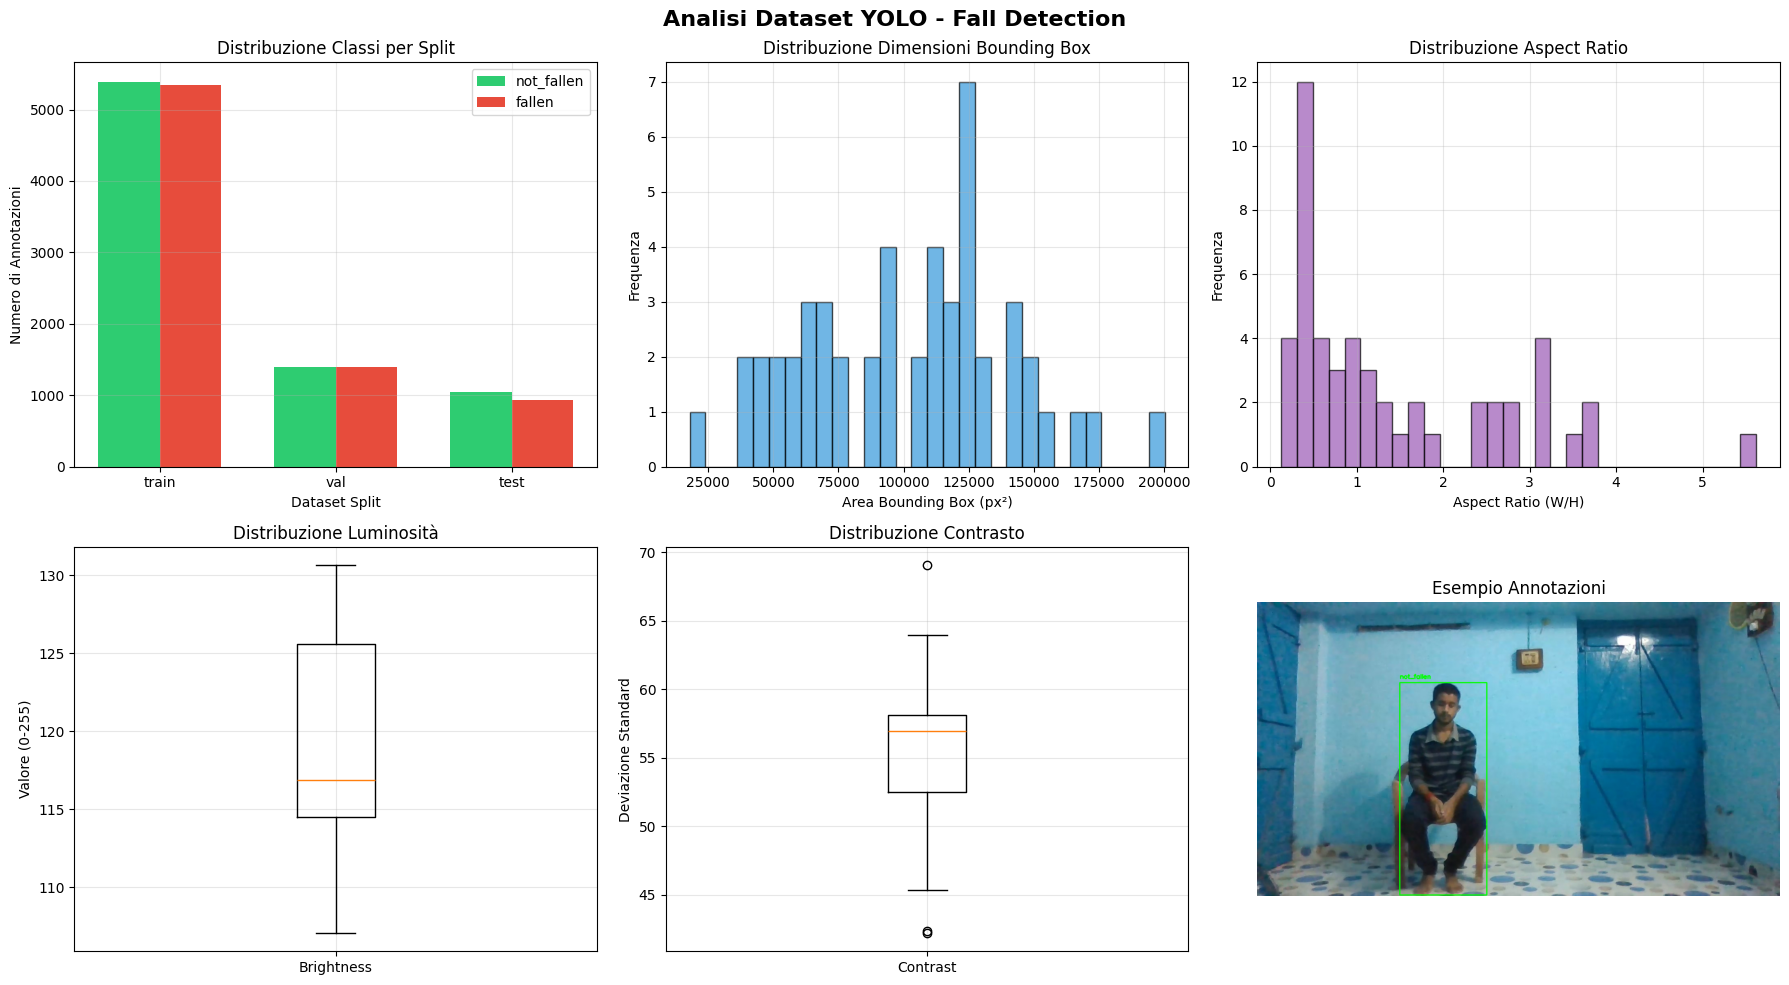

({'train': {0: 5392, 1: 5343},
  'val': {0: 1387, 1: 1393},
  'test': {0: 1037, 1: 929}},
 {'widths': [213.0816,
   661.53088,
   614.62272,
   182.4192,
   377.68384,
   188.73984000000002,
   215.71584000000001,
   319.16032,
   623.50464,
   213.37984,
   603.40224,
   373.49568,
   787.5929600000001,
   600.33152,
   323.56736,
   256.88448,
   232.40704,
   619.56224,
   569.08032,
   541.80608,
   272.13056,
   230.73664000000002,
   310.432,
   161.71136,
   470.31168,
   539.79264,
   276.79104,
   257.33632,
   120.03072,
   220.12416000000002,
   353.7152,
   213.93024,
   212.76928,
   270.21439999999996,
   673.50528,
   335.53024,
   172.20224000000002,
   214.04160000000002,
   173.79712,
   168.56448,
   168.70144,
   263.34208,
   427.23328000000004,
   240.91008,
   192.54656,
   47.614720000000005,
   726.95808,
   284.57536,
   300.51328,
   452.448],
  'heights': [579.84336,
   178.81127999999998,
   169.03296,
   405.5112,
   147.15024,
   384.64487999999994,
   57

In [6]:
print("\n🔍 FASE 1: Analisi Dataset")
trainer.analyze_dataset()


🔄 FASE 2: Data Augmentation

CREAZIONE DATASET AUGMENTATO

📁 Creando nuovo dataset in: /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset

🎨 ESEMPI DI AUGMENTATION


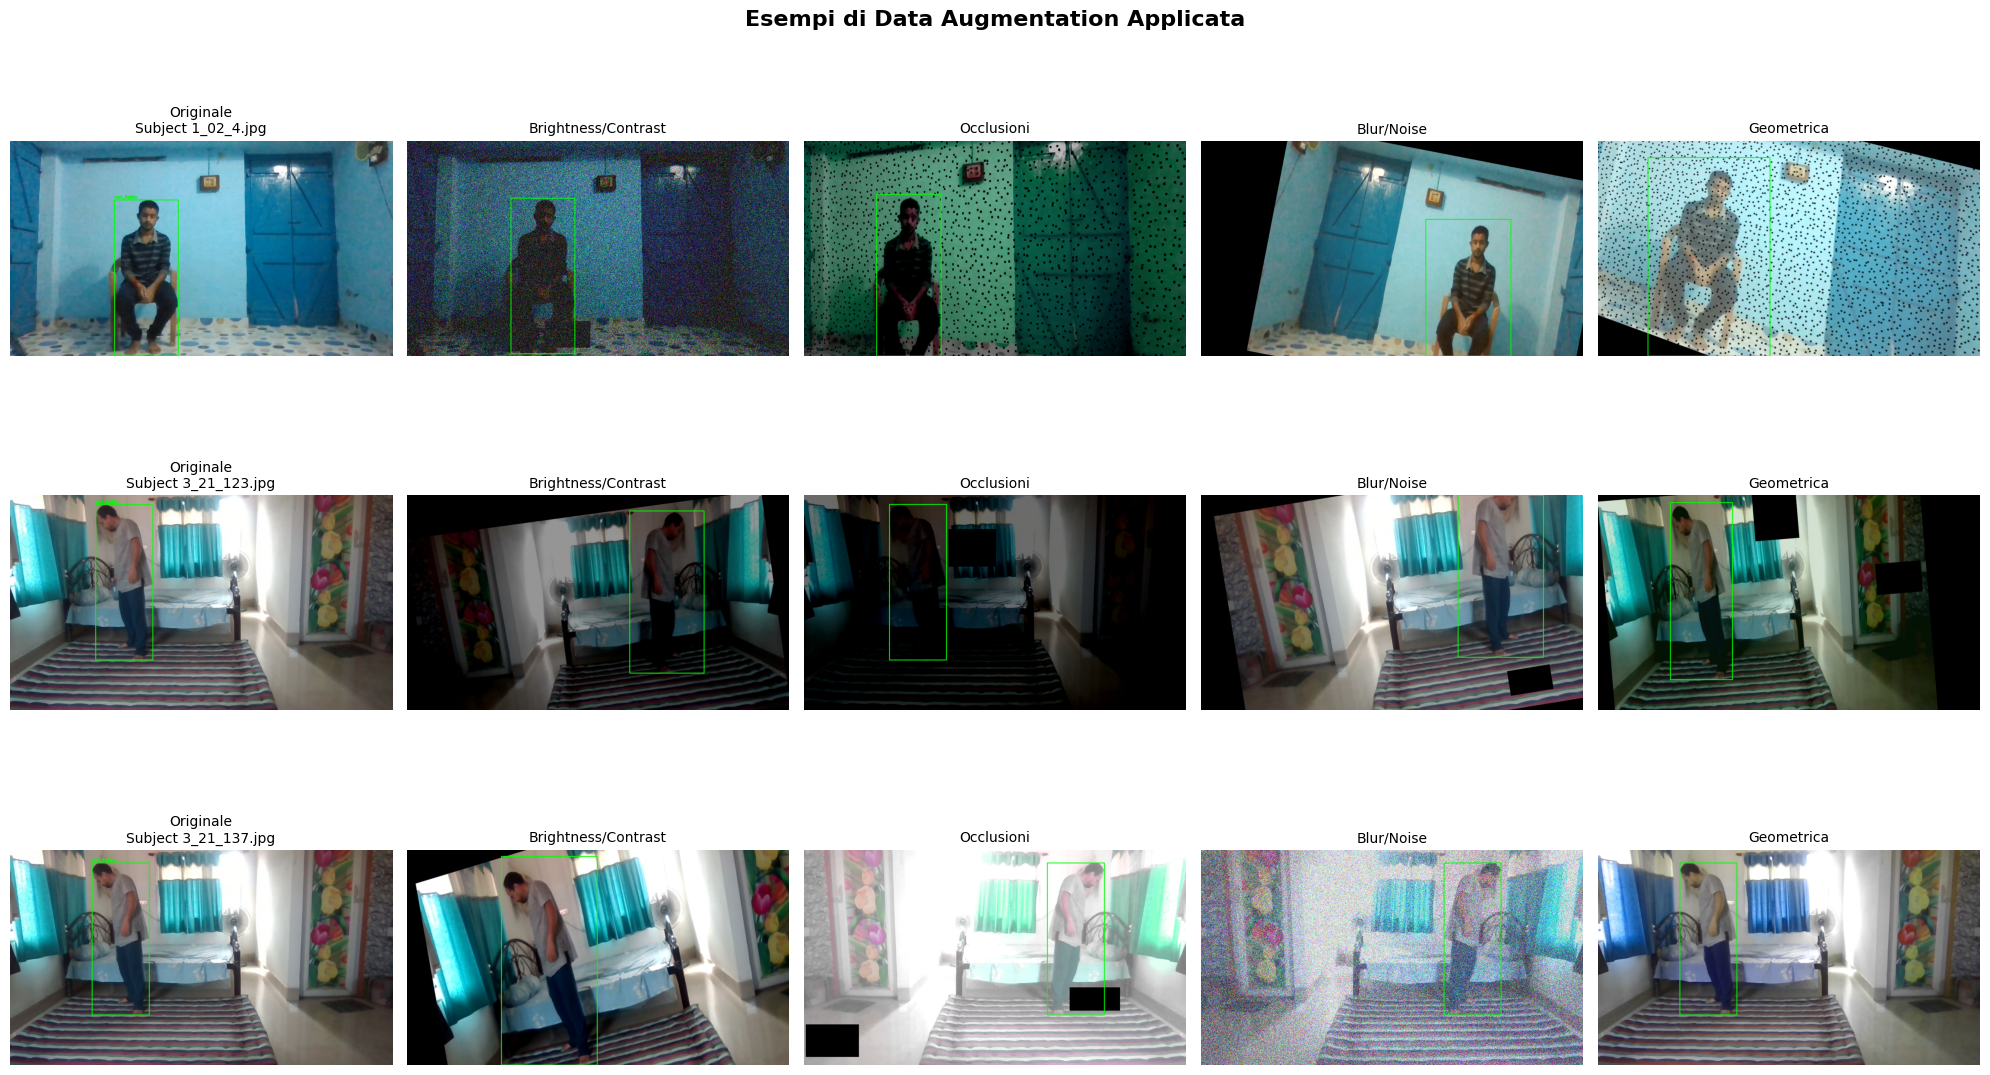


📌 AUGMENTATION APPLICATE:
  • Brightness/Contrast: ±40% variazione
  • Gamma/HSV/RGB shift: Simula diverse condizioni luce
  • Occlusioni: Rettangoli casuali, grid dropout
  • Blur: Motion, Gaussian, Median
  • Rumore: Gaussian, ISO noise
  • Geometriche: Rotazione ±15°, shift, scale, flip

📁 Processando train...
  • Applicando augmentation (fattore: 3x)...
    Processate 100/5604 immagini...
    Processate 200/5604 immagini...
    Processate 300/5604 immagini...
    Processate 400/5604 immagini...
    Processate 500/5604 immagini...
    Processate 600/5604 immagini...
    Processate 700/5604 immagini...
    Processate 800/5604 immagini...
    Processate 900/5604 immagini...
    Processate 1000/5604 immagini...
    Processate 1100/5604 immagini...
    Processate 1200/5604 immagini...
    Processate 1300/5604 immagini...
    Processate 1400/5604 immagini...
    Processate 1500/5604 immagini...
    Processate 1600/5604 immagini...
    Processate 1700/5604 immagini...
    Processate 1800

In [21]:
print("\n🔄 FASE 2: Data Augmentation")
response = input("\nVuoi creare un dataset augmentato? (s/n): ")
if response.lower() == 's':
    trainer.create_augmented_dataset(augmentation_factor=3, show_examples=True)

In [7]:
DATASET_PATH = "/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset"

# Verifica esistenza dataset
if not os.path.exists(DATASET_PATH):
    print("❌ ERRORE: Dataset non trovato!")
    print(f"Path specificato: {DATASET_PATH}")
    print("\nAssicurati che il dataset sia in formato YOLO con questa struttura:")
    print("balanced_yolo_dataset/")
    print("  ├── images/")
    print("  │   ├── train/")
    print("  │   ├── val/")
    print("  │   └── test/")
    print("  └── labels/")
    print("      ├── train/")
    print("      ├── val/")
    print("      └── test/")
else:
    print("✅ Dataset trovato!")
    print(f"📁 Directory: {DATASET_PATH}")
    
    # Verifica struttura directory
    dataset_path = Path(DATASET_PATH)
    images_dir = dataset_path / 'images'
    labels_dir = dataset_path / 'labels'
    
    if images_dir.exists() and labels_dir.exists():
        print("✅ Struttura dataset corretta!")
        
        # Verifica sottocartelle
        for split in ['train', 'val', 'test']:
            img_split = images_dir / split
            lbl_split = labels_dir / split
            print(f"\n{split.upper()}:")
            print(f"  • Images: {'✅' if img_split.exists() else '❌'} ({len(list(img_split.glob('*.jpg'))) if img_split.exists() else 0} files)")
            print(f"  • Labels: {'✅' if lbl_split.exists() else '❌'} ({len(list(lbl_split.glob('*.txt'))) if lbl_split.exists() else 0} files)")
        
        # Inizializza trainer
        trainer = YOLOFallDetectionTrainer(
            dataset_path=DATASET_PATH,
            model_name='yolo11n.pt',  # Usa yolo11n per CPU (più veloce)
            img_size=640  # Dimensione standard YOLO
        )
        

    else:
        print("❌ ERRORE: Struttura dataset non corretta!")
        print("Assicurati di avere le cartelle 'images' e 'labels' con sottocartelle train/val/test")

print("\n✅ Processo completato!")

# ====================================
# NOTE IMPORTANTI PER L'USO
# ====================================
print("\n" + "="*60)
print("📝 NOTE IMPORTANTI:")
print("="*60)
print("1. STRUTTURA DATASET:")
print("   Il tuo dataset DEVE avere questa struttura:")
print("   balanced_yolo_dataset/")
print("     ├── images/")
print("     │   ├── train/ (immagini .jpg)")
print("     │   ├── val/   (immagini .jpg)")
print("     │   └── test/  (immagini .jpg)")
print("     └── labels/")
print("         ├── train/ (file .txt)")
print("         ├── val/   (file .txt)")
print("         └── test/  (file .txt)")
print("\n2. FORMATO ANNOTAZIONI:")
print("   Ogni file .txt deve contenere:")
print("   <class_id> <x_center> <y_center> <width> <height>")
print("   dove: 0 = not_fallen, 1 = fallen")
print("\n3. OTTIMIZZAZIONI CPU:")
print("   - Usa YOLOv11n (nano) per velocità")
print("   - Batch size 16 (riduci se hai poca RAM)")
print("   - Cache attivata per velocizzare")
print("\n4. DATA AUGMENTATION:")
print("   - Focus su occlusioni e variazioni luminosità")
print("   - Fattore 3x consigliato per dataset piccoli")
print("   - Aumenta se hai <1000 immagini per classe")
# ====================================

✅ Dataset trovato!
📁 Directory: /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset
✅ Struttura dataset corretta!

TRAIN:
  • Images: ✅ (22359 files)
  • Labels: ✅ (22359 files)

VAL:
  • Images: ✅ (1600 files)
  • Labels: ✅ (1600 files)

TEST:
  • Images: ✅ (802 files)
  • Labels: ✅ (802 files)

✅ Processo completato!

📝 NOTE IMPORTANTI:
1. STRUTTURA DATASET:
   Il tuo dataset DEVE avere questa struttura:
   balanced_yolo_dataset/
     ├── images/
     │   ├── train/ (immagini .jpg)
     │   ├── val/   (immagini .jpg)
     │   └── test/  (immagini .jpg)
     └── labels/
         ├── train/ (file .txt)
         ├── val/   (file .txt)
         └── test/  (file .txt)

2. FORMATO ANNOTAZIONI:
   Ogni file .txt deve contenere:
   <class_id> <x_center> <y_center> <width> <height>
   dove: 0 = not_fallen, 1 = fallen

3. OTTIMIZZAZIONI CPU:
   - Usa YOLOv11n (nano) per velocità
   - Batch size 16 (riduci se hai poca RAM)


🚀 FASE 3: Training

TRAINING YOLO11 - FALL DETECTION

📦 Caricando modello: yolo11n.pt

⚙️ Configurazione Training:
  • Modello: yolo11n.pt
  • Immagini: 640x640
  • Batch size: 4
  • Epochs: 100
  • Device: CPU (ottimizzato)
  • Augmentation: Avanzata per occlusioni e luminosità

🚀 Avvio training...
New https://pypi.org/project/ultralytics/8.3.149 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.148 🚀 Python-3.11.13 torch-2.7.0 CPU (Apple M1 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=1.0, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/data.yaml, degrees=15, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok

train: Scanning /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/labels/train.cache... 22359 images, 674 backgrounds, 0 corrupt: 100%|██████████| 22359/22359 [00:00<?, ?it/s]


WARNING ⚠️ train: 22.3GB RAM required to cache images with 50% safety margin but only 4.1/16.0GB available, not caching images
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.2 ms, read: 821.1±278.5 MB/s, size: 214.2 KB)


val: Scanning /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/labels/val.cache... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (1.1GB RAM): 100%|██████████| 1600/1600 [00:00<00:00, 1899.62it/s]

Plotting labels to fall_detection/yolo11_cpu_optimized/labels.jpg... 


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to fall_detection/yolo11_cpu_optimized
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.679      3.577      1.682          4        640: 100%|██████████| 5590/5590 [1:24:59<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:46<00:00,  4.31it/s]

                   all       1600       1600       0.87      0.882      0.926      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.538      2.951      1.563          7        640: 100%|██████████| 5590/5590 [1:20:55<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:47<00:00,  4.23it/s]

                   all       1600       1600      0.905      0.897      0.939      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      3/100         0G      1.468      2.687      1.507          8        640: 100%|██████████| 5590/5590 [1:23:18<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:47<00:00,  4.22it/s]

                   all       1600       1600      0.916      0.871      0.935      0.697

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/100         0G       1.42      2.501      1.471          9        640: 100%|██████████| 5590/5590 [1:19:36<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.55it/s]

                   all       1600       1600      0.919       0.93      0.965      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.377      2.359      1.434          8        640: 100%|██████████| 5590/5590 [1:19:08<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.66it/s]

                   all       1600       1600      0.935      0.939      0.968      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/100         0G      1.357      2.277      1.419          5        640: 100%|██████████| 5590/5590 [1:17:51<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.57it/s]

                   all       1600       1600      0.942      0.936      0.971      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/100         0G      1.341      2.218      1.409          8        640: 100%|██████████| 5590/5590 [1:19:29<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.44it/s]

                   all       1600       1600      0.929      0.945      0.977      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      8/100         0G      1.313      2.165      1.391          4        640: 100%|██████████| 5590/5590 [1:18:21<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.48it/s]

                   all       1600       1600      0.942      0.954      0.978      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      9/100         0G      1.298      2.094      1.377          9        640: 100%|██████████| 5590/5590 [1:19:02<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.41it/s]

                   all       1600       1600      0.942      0.941      0.979      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     10/100         0G      1.282      2.054      1.361          8        640: 100%|██████████| 5590/5590 [1:18:41<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.36it/s]

                   all       1600       1600      0.958      0.951      0.982      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     11/100         0G      1.263      2.017      1.351          9        640: 100%|██████████| 5590/5590 [1:17:22<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.51it/s]

                   all       1600       1600      0.958      0.939      0.979      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/100         0G      1.257      1.992      1.351         12        640: 100%|██████████| 5590/5590 [1:16:32<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.41it/s]

                   all       1600       1600      0.957      0.937      0.981      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     13/100         0G      1.241      1.964      1.337          9        640: 100%|██████████| 5590/5590 [1:15:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:46<00:00,  4.34it/s]

                   all       1600       1600      0.944      0.957      0.987      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.228      1.924      1.329          5        640: 100%|██████████| 5590/5590 [1:18:37<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.53it/s]

                   all       1600       1600      0.949      0.971      0.985      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     15/100         0G      1.219        1.9      1.323          9        640: 100%|██████████| 5590/5590 [1:15:55<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.59it/s]

                   all       1600       1600      0.964       0.95      0.987      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     16/100         0G      1.213      1.891      1.318          8        640: 100%|██████████| 5590/5590 [1:16:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.36it/s]

                   all       1600       1600       0.96      0.966      0.988      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     17/100         0G      1.199      1.858      1.311          6        640: 100%|██████████| 5590/5590 [1:16:11<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.35it/s]

                   all       1600       1600      0.956      0.968      0.988      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     18/100         0G      1.195       1.85      1.305          4        640: 100%|██████████| 5590/5590 [1:19:39<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:49<00:00,  4.07it/s]

                   all       1600       1600      0.967      0.957      0.986      0.828

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     19/100         0G      1.191      1.832      1.302         12        640: 100%|██████████| 5590/5590 [1:20:31<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:46<00:00,  4.34it/s]

                   all       1600       1600       0.97      0.957      0.989      0.838

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     20/100         0G      1.184      1.806      1.297         10        640: 100%|██████████| 5590/5590 [1:16:43<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.62it/s]

                   all       1600       1600      0.971      0.954      0.988      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     21/100         0G      1.168      1.784      1.291          9        640: 100%|██████████| 5590/5590 [1:17:06<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:46<00:00,  4.34it/s]

                   all       1600       1600      0.961      0.966      0.989       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     22/100         0G      1.164       1.76      1.289          4        640: 100%|██████████| 5590/5590 [1:17:09<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.68it/s]

                   all       1600       1600      0.973      0.963      0.988      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.157      1.749      1.283          6        640: 100%|██████████| 5590/5590 [4:28:06<00:00,  2.88s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:48<00:00,  4.14it/s]

                   all       1600       1600      0.975      0.957       0.99      0.837

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     24/100         0G      1.156       1.75      1.283          7        640: 100%|██████████| 5590/5590 [5:11:48<00:00,  3.35s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [02:01<00:00,  1.64it/s]

                   all       1600       1600      0.975      0.958       0.99      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.142      1.731      1.274          5        640: 100%|██████████| 5590/5590 [11:42:15<00:00,  7.54s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:53<00:00,  3.75it/s]

                   all       1600       1600       0.97      0.965       0.99      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     26/100         0G      1.143      1.726      1.274          9        640: 100%|██████████| 5590/5590 [3:40:42<00:00,  2.37s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.88it/s]

                   all       1600       1600      0.968      0.968       0.99      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     27/100         0G      1.132      1.702      1.269          5        640: 100%|██████████| 5590/5590 [1:14:59<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.68it/s]

                   all       1600       1600      0.966      0.968      0.991      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     28/100         0G      1.135      1.698      1.268          8        640: 100%|██████████| 5590/5590 [1:15:47<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.73it/s]

                   all       1600       1600      0.971      0.964      0.991      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     29/100         0G      1.123      1.668      1.264          7        640: 100%|██████████| 5590/5590 [1:14:36<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.67it/s]

                   all       1600       1600      0.979      0.952      0.991      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     30/100         0G      1.116       1.67      1.258          8        640: 100%|██████████| 5590/5590 [1:14:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.86it/s]

                   all       1600       1600       0.98       0.96       0.99      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     31/100         0G      1.113      1.651      1.257          7        640: 100%|██████████| 5590/5590 [1:14:41<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s]

                   all       1600       1600      0.981      0.956      0.991      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.107      1.655      1.251          9        640: 100%|██████████| 5590/5590 [1:14:55<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.80it/s]

                   all       1600       1600      0.968      0.967      0.991      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     33/100         0G      1.106      1.638      1.251         13        640: 100%|██████████| 5590/5590 [1:14:26<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]

                   all       1600       1600      0.979      0.956      0.991      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     34/100         0G      1.103      1.627      1.251          9        640: 100%|██████████| 5590/5590 [1:15:28<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.70it/s]

                   all       1600       1600      0.975      0.962      0.991      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     35/100         0G      1.092      1.621      1.244          7        640: 100%|██████████| 5590/5590 [1:15:41<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s]

                   all       1600       1600      0.977      0.961      0.991      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     36/100         0G      1.098      1.608      1.247          4        640: 100%|██████████| 5590/5590 [1:15:39<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.67it/s]

                   all       1600       1600      0.978       0.96      0.991      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.086      1.606       1.24         11        640: 100%|██████████| 5590/5590 [1:17:07<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.80it/s]

                   all       1600       1600      0.974      0.962      0.991      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     38/100         0G      1.084      1.606      1.239          3        640: 100%|██████████| 5590/5590 [1:14:05<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]

                   all       1600       1600      0.974      0.966      0.991      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     39/100         0G       1.08      1.586      1.235         12        640: 100%|██████████| 5590/5590 [7:49:26<00:00,  5.04s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.69it/s]

                   all       1600       1600      0.973      0.965      0.991      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     40/100         0G      1.077      1.575      1.233          6        640: 100%|██████████| 5590/5590 [2:38:42<00:00,  1.70s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.71it/s]

                   all       1600       1600      0.978      0.958      0.991      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     41/100         0G      1.065      1.547      1.226          5        640: 100%|██████████| 5590/5590 [1:15:11<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.62it/s]

                   all       1600       1600      0.978      0.959      0.991      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.061      1.543      1.225          9        640: 100%|██████████| 5590/5590 [1:16:07<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.53it/s]

                   all       1600       1600      0.977      0.959      0.991      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     43/100         0G      1.061      1.547      1.224          4        640: 100%|██████████| 5590/5590 [1:15:17<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.66it/s]

                   all       1600       1600      0.976      0.961      0.991      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     44/100         0G      1.056       1.53       1.22          8        640: 100%|██████████| 5590/5590 [1:15:42<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.68it/s]

                   all       1600       1600      0.974      0.965      0.991      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     45/100         0G      1.053      1.518      1.217          7        640: 100%|██████████| 5590/5590 [1:14:59<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.72it/s]

                   all       1600       1600      0.974      0.967      0.991      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     46/100         0G      1.041      1.507      1.212         12        640: 100%|██████████| 5590/5590 [1:14:59<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.80it/s]

                   all       1600       1600      0.975      0.968      0.991       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.047      1.514      1.216         12        640: 100%|██████████| 5590/5590 [1:15:14<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.75it/s]

                   all       1600       1600      0.976      0.969      0.991       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     48/100         0G      1.041      1.502      1.213         15        640: 100%|██████████| 5590/5590 [1:14:43<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.68it/s]

                   all       1600       1600      0.976      0.969      0.991       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     49/100         0G      1.045      1.494      1.216          9        640: 100%|██████████| 5590/5590 [1:14:55<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.69it/s]

                   all       1600       1600      0.976      0.969      0.991       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     50/100         0G      1.028      1.474      1.206          5        640: 100%|██████████| 5590/5590 [1:15:14<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.72it/s]

                   all       1600       1600      0.976      0.969      0.991       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     51/100         0G      1.029      1.482      1.205          5        640: 100%|██████████| 5590/5590 [1:14:33<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.80it/s]

                   all       1600       1600      0.977      0.968      0.991       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.023      1.473      1.202         10        640: 100%|██████████| 5590/5590 [1:14:29<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.87it/s]

                   all       1600       1600      0.977      0.968      0.991      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     53/100         0G      1.018      1.469      1.199          7        640: 100%|██████████| 5590/5590 [1:13:58<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:40<00:00,  4.89it/s]

                   all       1600       1600      0.976      0.968      0.991      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     54/100         0G       1.02      1.466      1.201          8        640: 100%|██████████| 5590/5590 [1:13:48<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:40<00:00,  4.89it/s]

                   all       1600       1600      0.976      0.969      0.991       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     55/100         0G      1.016      1.454        1.2          6        640: 100%|██████████| 5590/5590 [1:13:41<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.86it/s]

                   all       1600       1600      0.976      0.969      0.991       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     56/100         0G      1.012       1.44      1.196          8        640: 100%|██████████| 5590/5590 [2:34:21<00:00,  1.66s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.70it/s]

                   all       1600       1600      0.976      0.969      0.991       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.005      1.433      1.192          6        640: 100%|██████████| 5590/5590 [1:15:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.64it/s]

                   all       1600       1600      0.976      0.969      0.991       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     58/100         0G      1.002      1.424      1.189          4        640: 100%|██████████| 5590/5590 [1:15:52<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.53it/s]

                   all       1600       1600      0.977      0.969      0.991       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     59/100         0G      1.004      1.431       1.19          7        640: 100%|██████████| 5590/5590 [1:13:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.86it/s]

                   all       1600       1600      0.977      0.969      0.991      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     60/100         0G      0.995      1.412      1.184          7        640: 100%|██████████| 5590/5590 [1:13:48<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.80it/s]

                   all       1600       1600      0.977      0.968      0.991      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     61/100         0G     0.9951      1.393      1.186          5        640: 100%|██████████| 5590/5590 [1:13:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.70it/s]

                   all       1600       1600      0.977      0.968      0.991      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.9893      1.406      1.184         10        640: 100%|██████████| 5590/5590 [1:14:52<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.71it/s]

                   all       1600       1600      0.977      0.968      0.991      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     63/100         0G     0.9841      1.394       1.18          7        640: 100%|██████████| 5590/5590 [1:14:48<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.70it/s]

                   all       1600       1600      0.972      0.973      0.991      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     64/100         0G     0.9823      1.387      1.179          6        640: 100%|██████████| 5590/5590 [1:15:08<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.85it/s]

                   all       1600       1600      0.972      0.973      0.991      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     65/100         0G     0.9787      1.381      1.177          7        640: 100%|██████████| 5590/5590 [1:14:17<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.52it/s]

                   all       1600       1600      0.973      0.974      0.991      0.893

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     66/100         0G     0.9799      1.377      1.178          9        640: 100%|██████████| 5590/5590 [1:16:05<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.62it/s]

                   all       1600       1600      0.973      0.975      0.991      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.9672      1.351      1.171          5        640: 100%|██████████| 5590/5590 [1:15:56<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.51it/s]

                   all       1600       1600      0.973      0.975      0.991      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     68/100         0G      0.974      1.374      1.174          6        640: 100%|██████████| 5590/5590 [1:15:26<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:44<00:00,  4.50it/s]

                   all       1600       1600      0.975      0.976      0.992      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     69/100         0G     0.9675      1.366      1.172          6        640: 100%|██████████| 5590/5590 [1:14:50<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.39it/s]

                   all       1600       1600      0.975      0.976      0.992      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     70/100         0G     0.9607      1.335      1.166          5        640: 100%|██████████| 5590/5590 [1:22:34<00:00,  1.13it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [02:12<00:00,  1.51it/s]

                   all       1600       1600      0.975      0.976      0.992      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     71/100         0G     0.9596       1.33      1.165          7        640: 100%|██████████| 5590/5590 [1:42:27<00:00,  1.10s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.56it/s]

                   all       1600       1600      0.975      0.976      0.992      0.895

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     72/100         0G     0.9519      1.332      1.161          4        640: 100%|██████████| 5590/5590 [1:46:03<00:00,  1.14s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.43it/s]

                   all       1600       1600      0.976      0.976      0.992      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     73/100         0G     0.9518      1.328      1.164          6        640: 100%|██████████| 5590/5590 [1:15:33<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.70it/s]

                   all       1600       1600      0.976      0.978      0.992      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     74/100         0G     0.9429      1.316      1.161          4        640: 100%|██████████| 5590/5590 [1:12:57<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s]

                   all       1600       1600      0.976      0.978      0.992      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     75/100         0G     0.9354      1.304      1.155          8        640: 100%|██████████| 5590/5590 [1:13:39<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.80it/s]

                   all       1600       1600      0.976      0.978      0.992      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.9343      1.308      1.155          8        640: 100%|██████████| 5590/5590 [1:14:08<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.55it/s]

                   all       1600       1600      0.977      0.978      0.992      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     77/100         0G     0.9307      1.301      1.153         10        640: 100%|██████████| 5590/5590 [1:13:39<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.44it/s]

                   all       1600       1600      0.977      0.979      0.992      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     78/100         0G     0.9312      1.293      1.153          7        640: 100%|██████████| 5590/5590 [1:14:30<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:46<00:00,  4.29it/s]

                   all       1600       1600      0.976      0.978      0.992      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     79/100         0G      0.926      1.277       1.15          6        640: 100%|██████████| 5590/5590 [1:13:41<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.73it/s]

                   all       1600       1600      0.976      0.979      0.992      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     80/100         0G     0.9234      1.275      1.149          6        640: 100%|██████████| 5590/5590 [1:14:17<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:40<00:00,  4.90it/s]

                   all       1600       1600      0.976      0.978      0.992      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     81/100         0G     0.9179      1.265      1.149          8        640: 100%|██████████| 5590/5590 [1:13:32<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.73it/s]

                   all       1600       1600      0.976      0.978      0.992      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     82/100         0G     0.9147       1.26      1.145          5        640: 100%|██████████| 5590/5590 [1:13:33<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.84it/s]

                   all       1600       1600      0.976      0.978      0.992        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     83/100         0G     0.9047      1.246      1.139          9        640: 100%|██████████| 5590/5590 [1:13:59<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:40<00:00,  4.91it/s]

                   all       1600       1600      0.977      0.978      0.992      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     84/100         0G     0.9054      1.246      1.139          3        640: 100%|██████████| 5590/5590 [1:13:47<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.78it/s]

                   all       1600       1600      0.977      0.978      0.992      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     85/100         0G     0.8993      1.242      1.137          3        640: 100%|██████████| 5590/5590 [1:18:07<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.35it/s]

                   all       1600       1600      0.977      0.978      0.992      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.8928      1.226      1.132          9        640: 100%|██████████| 5590/5590 [1:16:19<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.58it/s]

                   all       1600       1600      0.977      0.978      0.992      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     87/100         0G     0.8916      1.223       1.13          6        640: 100%|██████████| 5590/5590 [1:17:01<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:45<00:00,  4.44it/s]

                   all       1600       1600      0.977      0.978      0.992      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     88/100         0G     0.8884      1.217      1.131          9        640: 100%|██████████| 5590/5590 [1:15:09<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.69it/s]

                   all       1600       1600      0.977      0.978      0.992      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     89/100         0G     0.8852      1.216      1.127          9        640: 100%|██████████| 5590/5590 [1:15:16<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:43<00:00,  4.63it/s]

                   all       1600       1600      0.977      0.978      0.992      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     90/100         0G      0.885      1.221      1.131         10        640: 100%|██████████| 5590/5590 [1:54:09<00:00,  1.23s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.76it/s]

                   all       1600       1600      0.977      0.978      0.992      0.904


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.6039     0.6118     0.9589          3        640: 100%|██████████| 5590/5590 [1:11:45<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.83it/s]

                   all       1600       1600      0.977      0.978      0.992      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     92/100         0G     0.5853     0.5966       0.95          3        640: 100%|██████████| 5590/5590 [1:10:55<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.73it/s]

                   all       1600       1600      0.977      0.978      0.992      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     93/100         0G     0.5773     0.5829     0.9461          3        640: 100%|██████████| 5590/5590 [1:11:42<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:40<00:00,  4.91it/s]

                   all       1600       1600      0.977      0.978      0.992      0.905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     94/100         0G     0.5723     0.5755     0.9426          3        640: 100%|██████████| 5590/5590 [1:11:30<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.81it/s]

                   all       1600       1600      0.978      0.978      0.992      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     95/100         0G     0.5636     0.5646     0.9407          3        640: 100%|██████████| 5590/5590 [1:11:45<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:42<00:00,  4.70it/s]

                   all       1600       1600      0.978      0.978      0.992      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     96/100         0G     0.5599     0.5558     0.9379          3        640: 100%|██████████| 5590/5590 [1:11:43<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:40<00:00,  4.92it/s]

                   all       1600       1600      0.978      0.978      0.992      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     97/100         0G       0.55     0.5491     0.9347          3        640: 100%|██████████| 5590/5590 [1:11:51<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.77it/s]

                   all       1600       1600      0.978      0.977      0.992      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     98/100         0G     0.5431     0.5429     0.9311          3        640: 100%|██████████| 5590/5590 [1:10:58<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:40<00:00,  4.96it/s]

                   all       1600       1600      0.978      0.977      0.992      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     99/100         0G      0.539     0.5338     0.9276          3        640: 100%|██████████| 5590/5590 [1:11:24<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:40<00:00,  4.91it/s]

                   all       1600       1600      0.978      0.977      0.992      0.909

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



    100/100         0G     0.5371     0.5311     0.9287          3        640: 100%|██████████| 5590/5590 [1:11:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [00:41<00:00,  4.85it/s]

                   all       1600       1600      0.978      0.977      0.992       0.91

100 epochs completed in 157.954 hours.


Optimizer stripped from fall_detection/yolo11_cpu_optimized/weights/last.pt, 5.5MB
Optimizer stripped from fall_detection/yolo11_cpu_optimized/weights/best.pt, 5.5MB

Validating fall_detection/yolo11_cpu_optimized/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.13 torch-2.7.0 CPU (Apple M1 Pro)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


                   all       1600       1600      0.962      0.978      0.991      0.884
            not_fallen        800        800      0.971      0.984      0.994      0.889
                fallen        800        800      0.952      0.972      0.989       0.88
Speed: 0.3ms preprocess, 51.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to fall_detection/yolo11_cpu_optimized

📊 Valutazione modello...
Ultralytics 8.3.148 🚀 Python-3.11.13 torch-2.7.0 CPU (Apple M1 Pro)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 725.6±288.7 MB/s, size: 175.2 KB)


val: Scanning /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/augmented_yolo_dataset/labels/val.cache... 1600 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1600/1600 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (1.1GB RAM): 100%|██████████| 1600/1600 [00:00<00:00, 1864.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 400/400 [01:36<00:00,  4.13it/s]


                   all       1600       1600      0.962      0.978      0.991      0.884
            not_fallen        800        800      0.971      0.984      0.994      0.889
                fallen        800        800      0.952      0.972      0.989       0.88
Speed: 0.2ms preprocess, 58.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to fall_detection/yolo11_cpu_optimized

✅ Modello migliore salvato: best_fall_detection_yolo11.pt


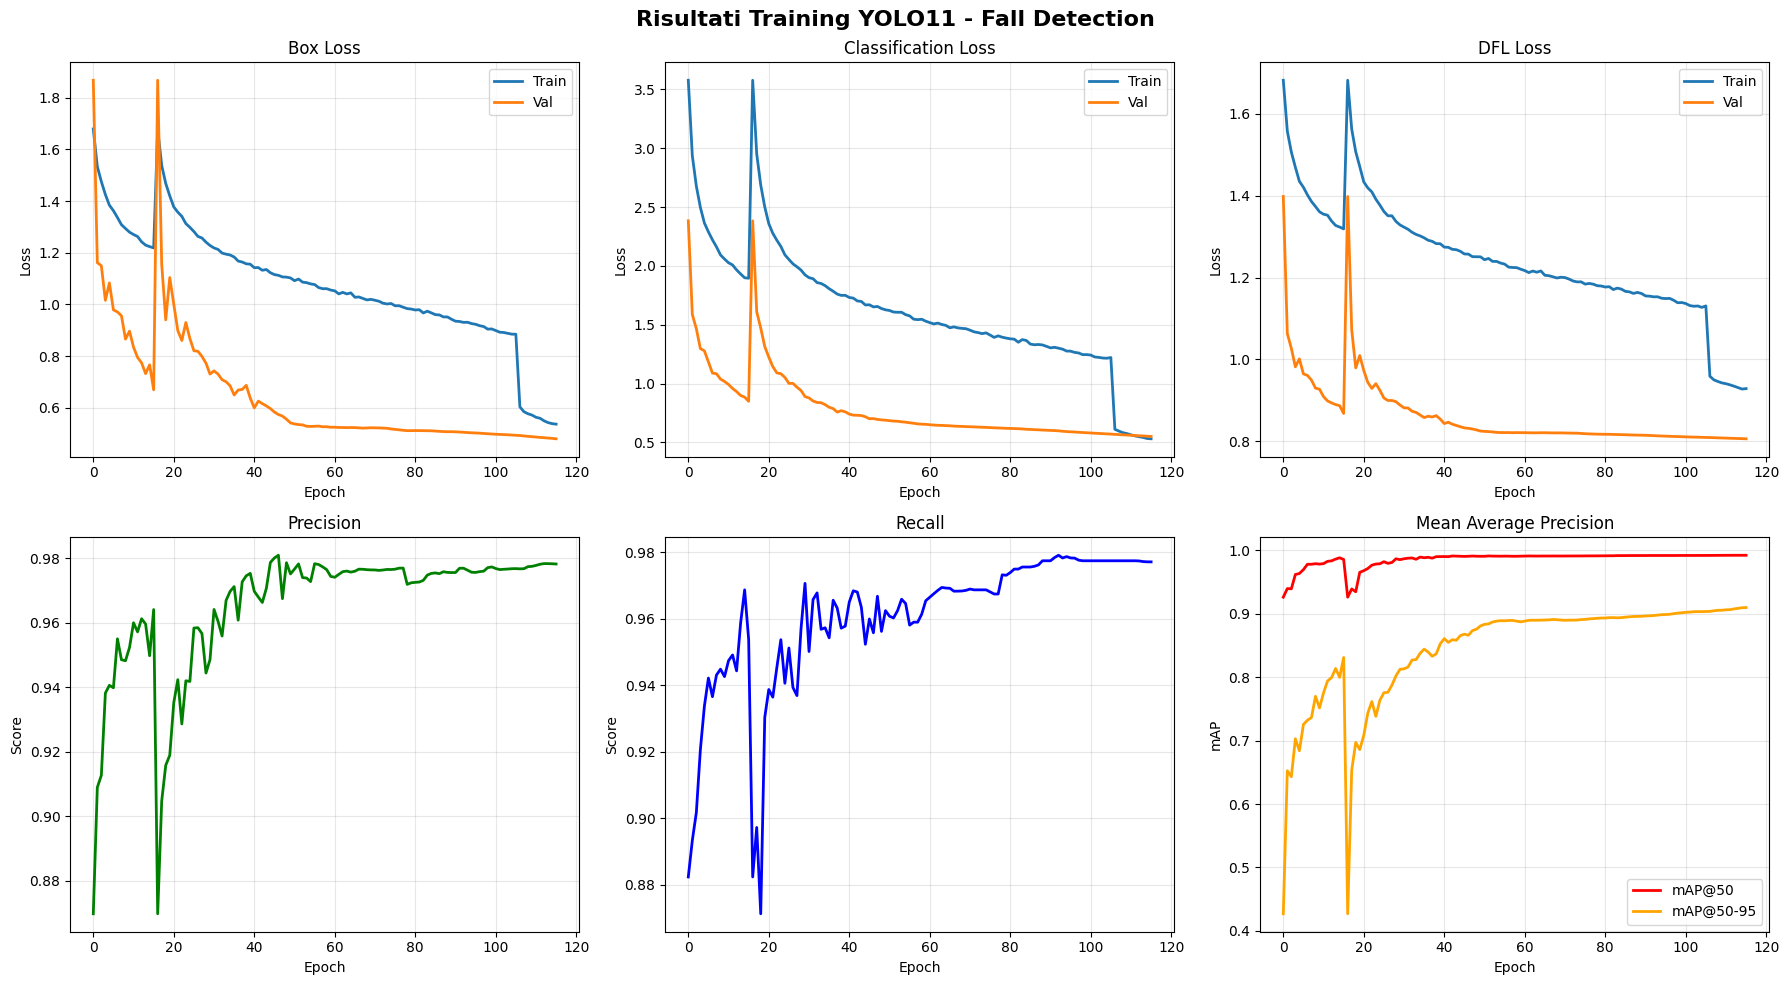


📊 METRICHE FINALI:
  • Precision: 0.978
  • Recall: 0.977
  • mAP@50: 0.992
  • mAP@50-95: 0.910


In [8]:
print("\n🚀 FASE 3: Training")
response = input("\nVuoi avviare il training? (s/n): ")
if response.lower() == 's':
    model, results, metrics = trainer.train_model(
        epochs=100,  
        patience=15,
        batch_size=4  # Riduci se hai poca RAM
)

In [9]:
print("\n📊 FASE 4: Test e Valutazione")
if os.path.exists('best_fall_detection_yolo11.pt'):
    trainer.test_model()
    trainer.create_confusion_matrix_advanced()


📊 FASE 4: Test e Valutazione

TEST MODELLO YOLO11
Ultralytics 8.3.148 🚀 Python-3.11.13 torch-2.7.0 CPU (Apple M1 Pro)


YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 846.9±430.2 MB/s, size: 299.1 KB)


val: Scanning /Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/Datasets/balanced_yolo_dataset/labels/test.cache... 1761 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1761/1761 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 111/111 [04:03<00:00,  2.19s/it]


                   all       1761       1966      0.879      0.617      0.704      0.527
            not_fallen        880       1037      0.854      0.494      0.562      0.451
                fallen        926        929      0.904      0.741      0.847      0.602
Speed: 0.3ms preprocess, 129.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Saving /Users/andreavisi/Desktop/PYTHON/runs/detect/val3/predictions.json...
Results saved to /Users/andreavisi/Desktop/PYTHON/runs/detect/val3

📊 PERFORMANCE PER CLASSE:

  not_fallen:
    • Precision: 0.854
    • Recall: 0.494
    • mAP@50: 0.562
    • mAP@50-95: 0.451

  fallen:
    • Precision: 0.904
    • Recall: 0.741
    • mAP@50: 0.847
    • mAP@50-95: 0.602

CONFUSION MATRIX AVANZATA


<Figure size 1000x800 with 2 Axes>


📊 REPORT DETTAGLIATO:
              precision    recall  f1-score   support

  not_fallen      0.995     0.978     0.986       401
      fallen      0.978     0.995     0.986       401

    accuracy                          0.986       802
   macro avg      0.986     0.986     0.986       802
weighted avg      0.986     0.986     0.986       802


📈 STATISTICHE AGGIUNTIVE:
  • Immagini testate: 802
  • Rilevamenti mancati: 0
  • Confidence media: 0.866
  • Confidence min/max: 0.252 / 0.921


In [ ]:
print("\n🖼️ FASE 5: Test Predizione")
test_image = input("\nInserisci il path di un'immagine di test (o premi Enter per saltare): ")
if test_image and os.path.exists(test_image):
    trainer.predict_image(test_image)

In [14]:
from ultralytics import YOLO
import cv2

def monitor_video_stream(model, source=0):
    """Monitora uno stream video per rilevare cadute."""
    import cv2
    
    # Apri stream video
    cap = cv2.VideoCapture(source)
    
    while cap.isOpened():
        # Leggi frame
        success, frame = cap.read()
        if not success:
            break
        
        # Converti colori per YOLOv11
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Predici
        results = model.predict(frame_rgb, conf=0.5)
        
        # Processa risultati
        annotated_frame = results[0].plot()
        
        # Converti colori per visualizzazione
        annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
        
        # Mostra
        cv2.imshow("YOLOv11 Fallen Person Detection", annotated_frame)
        
        # Premi 'q' per uscire
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Rilascia risorse
    cap.release()
    cv2.destroyAllWindows()

model_path = "/Users/andreavisi/Desktop/PYTHON/Sistemi operativi Dedicati 2025/PROGETTO/Eyes_on_falls_YOLO/3. fallen_people_detection/best_fall_detection_yolo11.pt"
model = YOLO(model_path)
#model = YOLO('yolo11n.pt')

# Avvia monitoraggio (webcam)
monitor_video_stream(model, 0)


0: 384x640 (no detections), 49.8ms
Speed: 1.9ms preprocess, 49.8ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 46.0ms
Speed: 1.7ms preprocess, 46.0ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 not_fallen, 45.5ms
Speed: 1.4ms preprocess, 45.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 45.7ms
Speed: 1.6ms preprocess, 45.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 43.1ms
Speed: 1.7ms preprocess, 43.1ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 44.3ms
Speed: 1.7ms preprocess, 44.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 40.9ms
Speed: 1.7ms preprocess, 40.9ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 42.1ms
Speed: 1.5ms preprocess, 42.1ms infe